# Explore differential expression analysis results

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import pymde
import hdbscan
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

In [2]:
datadir = '/Users/rzhu/Gladstone Dropbox/Ronghui Zhu/GRNPerturbSeq/3_expts/processed_data/CD4i_final'
experiment_name = 'CD4i_final'

In [174]:
# guide_effect_rest = pd.read_csv(datadir + f'/CD4i_final.guide_effect.Rest.csv', index_col=0)
# guide_effect_stim8hr = pd.read_csv(datadir + f'/CD4i_final.guide_effect.Stim8hr.csv', index_col=0)
# guide_effect_stim48hr = pd.read_csv(datadir + f'/CD4i_final.guide_effect.Stim48hr.csv', index_col=0)
# guide_effect_rest['target_gene'] = guide_effect_rest.index.str[:-2]
# guide_effect_stim8hr['target_gene'] = guide_effect_stim8hr.index.str[:-2]
# guide_effect_stim48hr['target_gene'] = guide_effect_stim48hr.index.str[:-2]
# # Consider significant KD if at least one of the two sgRNA worked
# guide_effect_rest = guide_effect_rest[['signif_knockdown', 'target_gene']]
# guide_effect_rest = guide_effect_rest.reset_index(drop=True)
# guide_effect_rest = guide_effect_rest.drop_duplicates()
# duplicate_rows_mask = guide_effect_rest.duplicated(subset=['target_gene'], keep=False)
# guide_effect_rest.loc[duplicate_rows_mask, 'signif_knockdown'] = True
# guide_effect_rest = guide_effect_rest.drop_duplicates()
# # Consider significant KD if at least one of the two sgRNA worked
# guide_effect_stim8hr = guide_effect_stim8hr[['signif_knockdown', 'target_gene']]
# guide_effect_stim8hr = guide_effect_stim8hr.reset_index(drop=True)
# guide_effect_stim8hr = guide_effect_stim8hr.drop_duplicates()
# duplicate_rows_mask = guide_effect_stim8hr.duplicated(subset=['target_gene'], keep=False)
# guide_effect_stim8hr.loc[duplicate_rows_mask, 'signif_knockdown'] = True
# guide_effect_stim8hr = guide_effect_stim8hr.drop_duplicates()
# # Consider significant KD if at least one of the two sgRNA worked
# guide_effect_stim48hr = guide_effect_stim48hr[['signif_knockdown', 'target_gene']]
# guide_effect_stim48hr = guide_effect_stim48hr.reset_index(drop=True)
# guide_effect_stim48hr = guide_effect_stim48hr.drop_duplicates()
# duplicate_rows_mask = guide_effect_stim48hr.duplicated(subset=['target_gene'], keep=False)
# guide_effect_stim48hr.loc[duplicate_rows_mask, 'signif_knockdown'] = True
# guide_effect_stim48hr = guide_effect_stim48hr.drop_duplicates()

## Read best DE results, filter based on number of DE genes and on-target KD effects

In [3]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results_corrected.h5ad')

In [4]:
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

In [5]:
de_summary_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

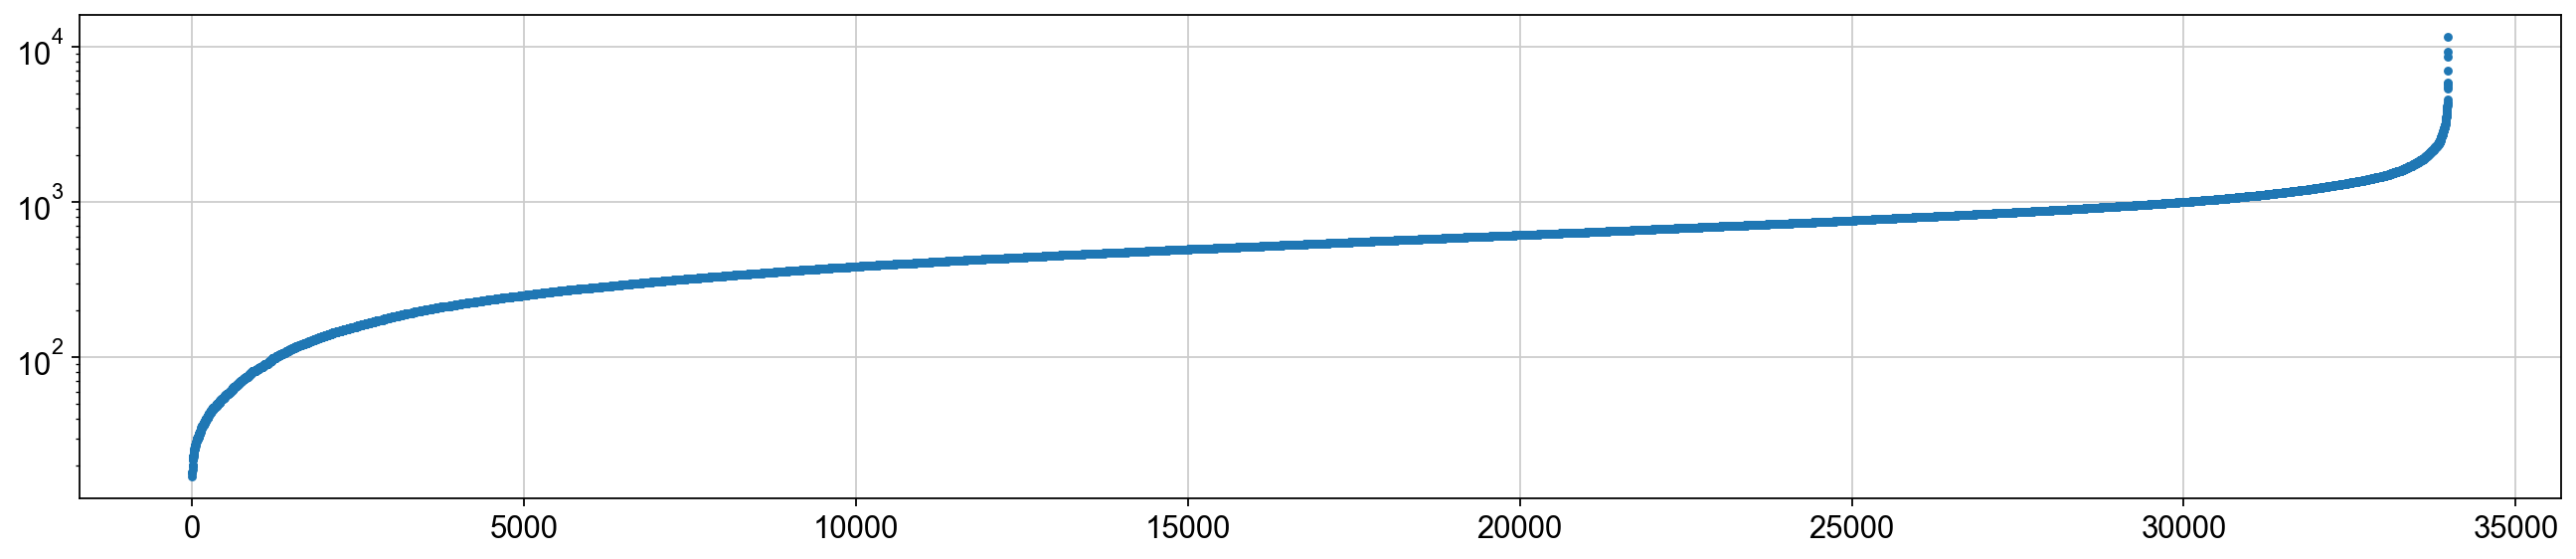

In [6]:
plt.plot(np.sort(de_summary_stats.n_cells_target), '.')
plt.yscale('log')

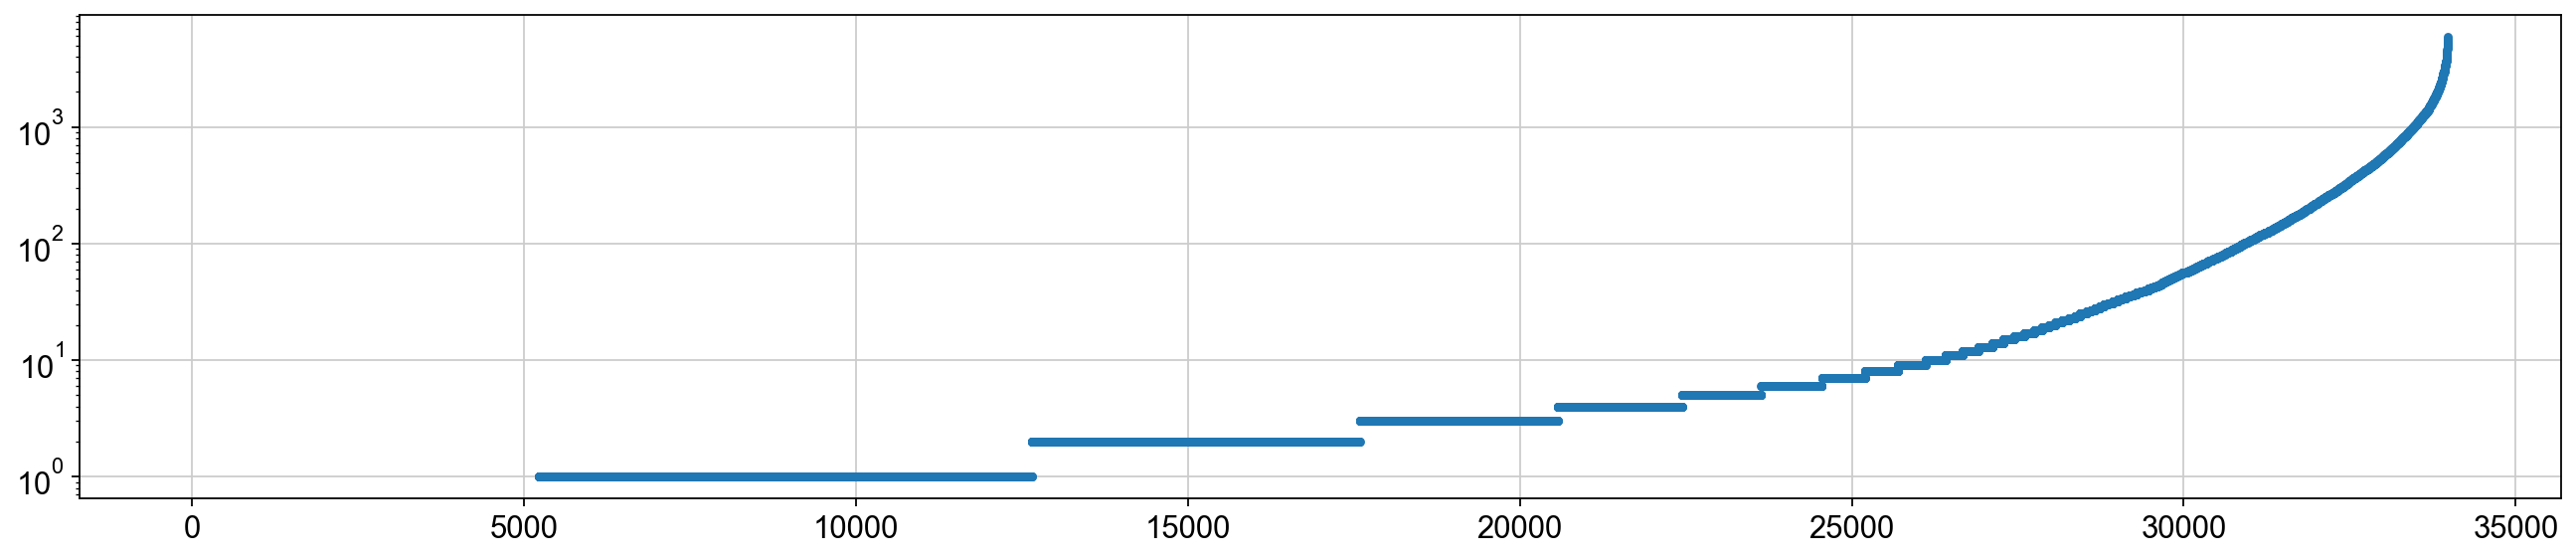

In [7]:
plt.plot(np.sort(de_summary_stats.n_total_de_genes), '.')
plt.yscale('log')

In [8]:
mask = (de_summary_stats.n_total_de_genes>50) & (de_summary_stats.n_cells_target>100)# & (de_summary_stats.ontarget_effect_category=='on-target KD')
obs_names_mask = de_summary_stats[mask].obs_names
adata_de_filtered = adata_de[adata_de.obs_names.isin(obs_names_mask)].copy()
adata_de_filtered.var_names = adata_de_filtered.var.gene_name
adata_de_filtered.X = np.nan_to_num(adata_de_filtered.layers['zscore'], 0)

In [183]:
# gene_rest = guide_effect_rest[guide_effect_rest.signif_knockdown==True].target_gene.tolist()
# gene_rest = gene_rest + de_summary_stats[(de_summary_stats.ontarget_significant==True)&(de_summary_stats.condition=='Rest')].target_name.tolist()
# obs_names_rest = adata_de_filtered[(adata_de_filtered.obs.target_contrast_gene_name.isin(gene_rest))&(adata_de_filtered.obs.culture_condition=='Rest')].obs_names
# gene_stim8hr = guide_effect_stim8hr[guide_effect_stim8hr.signif_knockdown==True].target_gene.tolist()
# gene_stim8hr = gene_stim8hr + de_summary_stats[(de_summary_stats.ontarget_significant==True)&(de_summary_stats.condition=='Stim8hr')].target_name.tolist()
# obs_names_stim8hr = adata_de_filtered[(adata_de_filtered.obs.target_contrast_gene_name.isin(gene_stim8hr))&(adata_de_filtered.obs.culture_condition=='Stim8hr')].obs_names
# gene_stim48hr = guide_effect_stim48hr[guide_effect_stim48hr.signif_knockdown==True].target_gene.tolist()
# gene_stim48hr = gene_stim48hr + de_summary_stats[(de_summary_stats.ontarget_significant==True)&(de_summary_stats.condition=='Stim48hr')].target_name.tolist()
# obs_names_stim48hr = adata_de_filtered[(adata_de_filtered.obs.target_contrast_gene_name.isin(gene_stim48hr))&(adata_de_filtered.obs.culture_condition=='Stim48hr')].obs_names
# obs_names_all = np.concatenate([obs_names_rest, obs_names_stim8hr, obs_names_stim48hr])
# adata_de_filtered = adata_de_filtered[adata_de_filtered.obs_names.isin(obs_names_all)].copy()

In [9]:
adata_de_filtered

AnnData object with n_obs × n_vars = 3621 × 13959
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

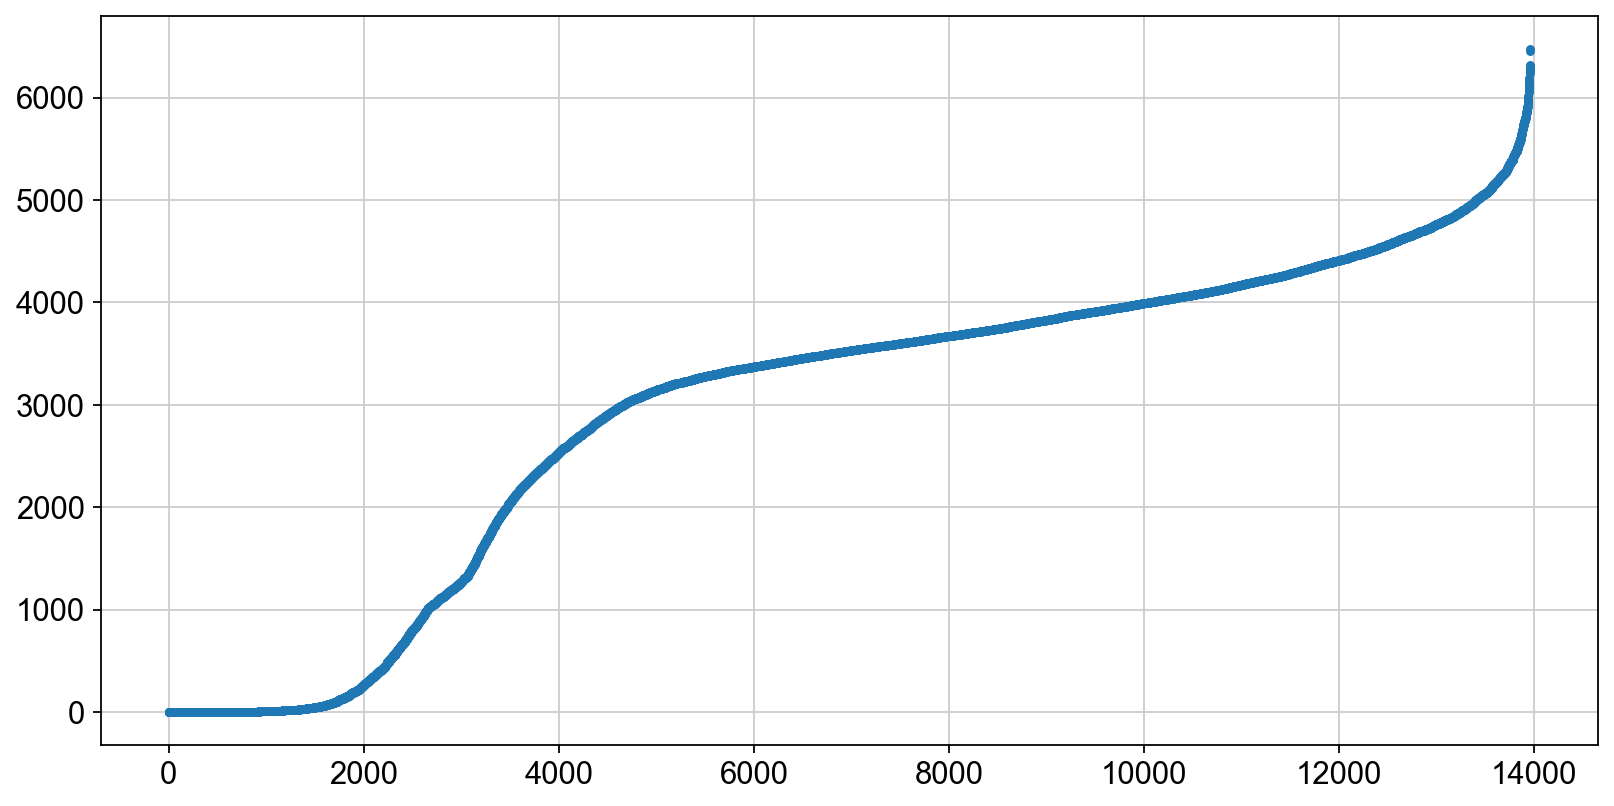

In [10]:
fig, ax = plt.subplots(figsize=(12,6))
plt.plot(np.sort(np.abs(adata_de_filtered.X).sum(0)), '.')

In [77]:
adata_de_filtered = adata_de_filtered[:,np.abs(adata_de_filtered.X).sum(0)>1500].copy()

In [78]:
adata_de_filtered

AnnData object with n_obs × n_vars = 3621 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [79]:
adata_de_filtered.write_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

In [17]:
adata_de_filtered = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')
adata_cluster = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

### Simple PCA clustering

In [81]:
sc.pp.scale(adata_cluster)

In [82]:
sc.pp.pca(adata_cluster, n_comps=300)

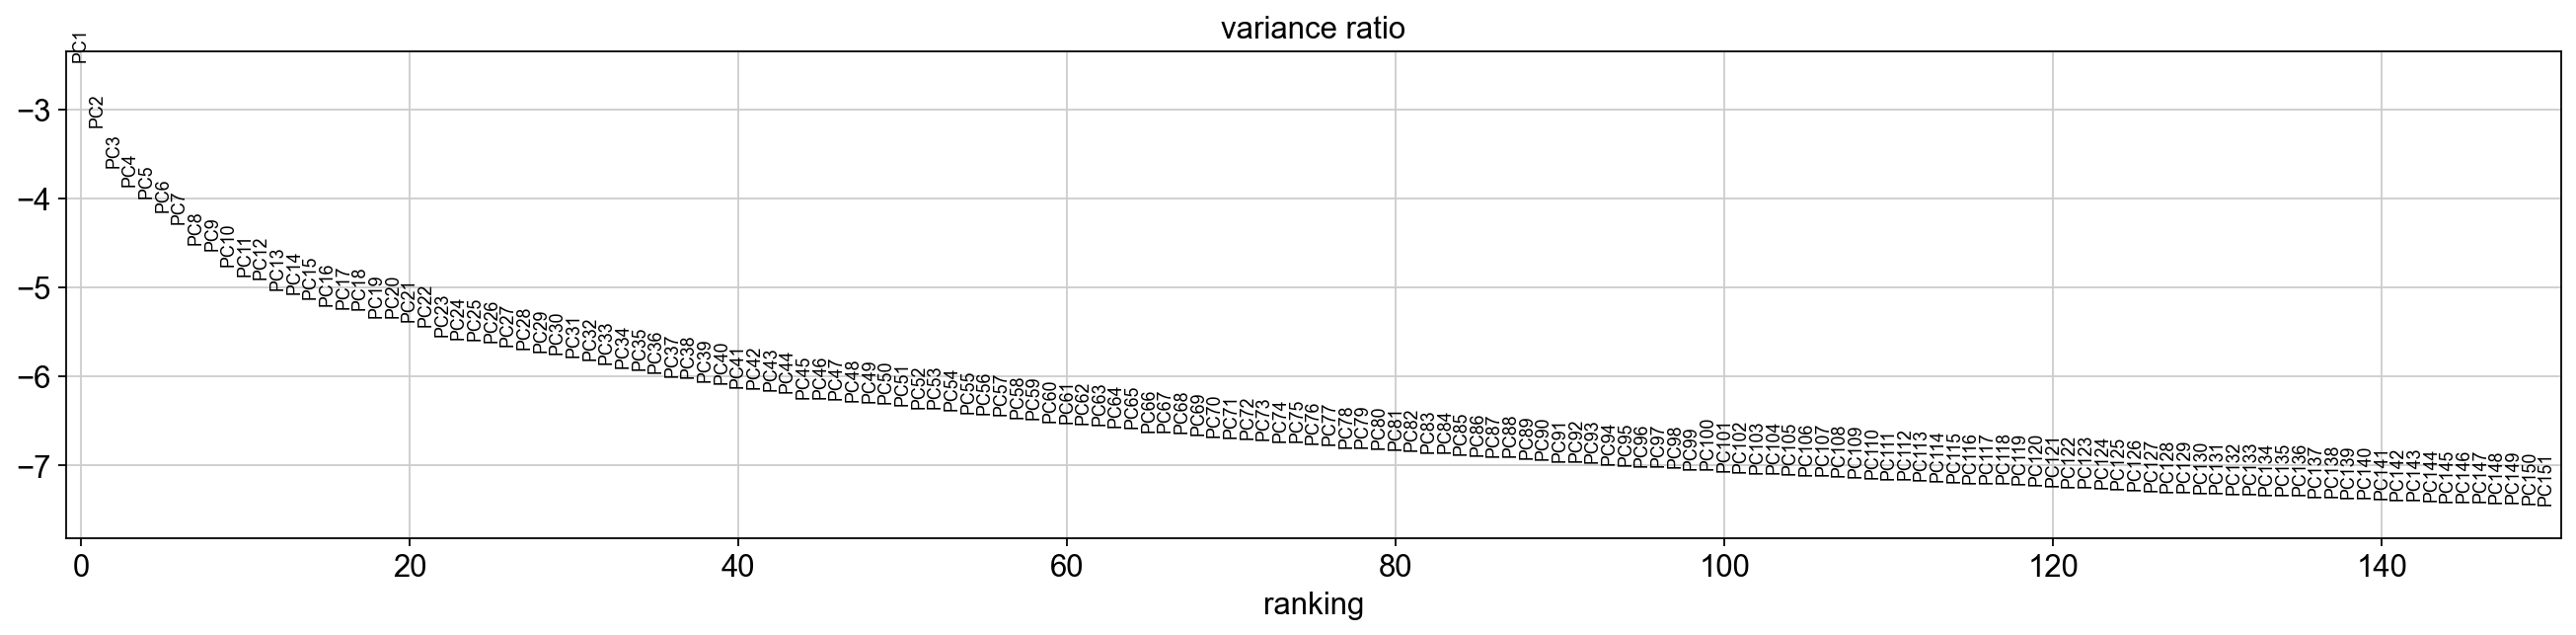

In [83]:
sc.pl.pca_variance_ratio(adata_cluster, n_pcs=150, log=True)

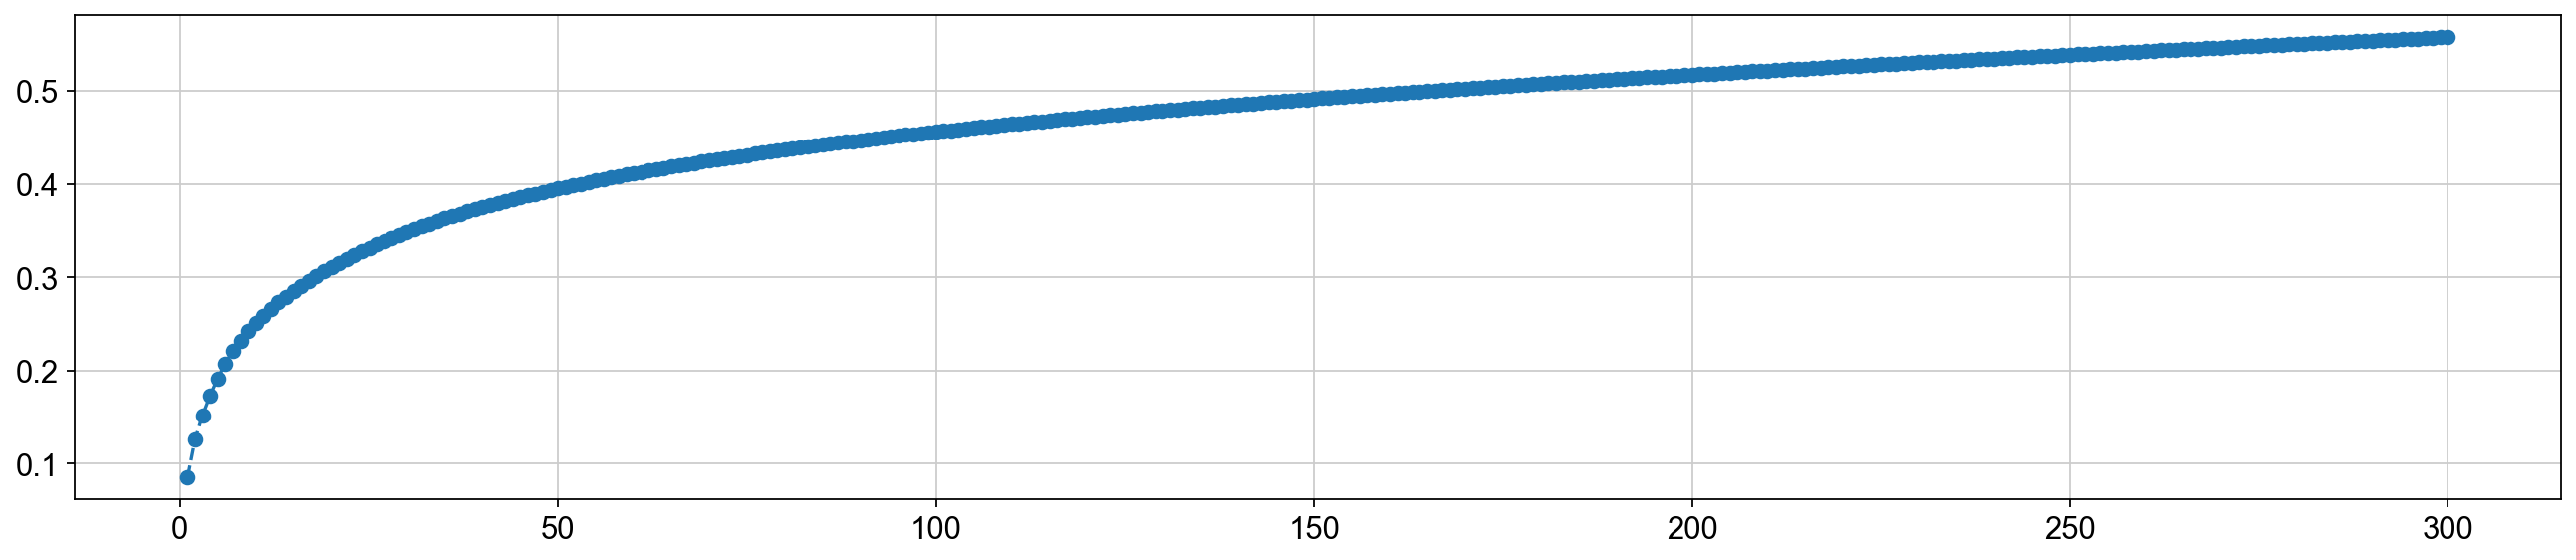

In [84]:
variance_ratio = adata_cluster.uns['pca']['variance_ratio']
cumulative_variance_ratio = np.cumsum(variance_ratio)
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')

In [11]:
adata_cluster = sc.read_h5ad('../../../RZAnalysisCodes/results/adata_de_nde50ntotal100_varfiltered.h5ad')

In [4]:
def generate_masks(data_length: int, percentage: float, num_times: int, random_seed=42) -> List[List[bool]]:
    np.random.seed(random_seed)
    sample_size = int(data_length * (percentage / 100.0))
    masks = []
    for _ in range(num_times):
        indices = np.random.choice(data_length, size=sample_size, replace=False)
        mask = np.zeros(data_length, dtype=bool)
        mask[indices] = True
        masks.append(mask)
    return masks


def running_clustering(obs_mask, var_mask, n_comp_all=[50,100,150], n_neighbor_all=[15,31,63], resolution_all=[2,3,4]):
    """
    Running leiden clustering with parameter grid
    """
    N = len(adata_cluster)
    # Subsetting the adata
    adata_tmp = adata_cluster[obs_mask, var_mask].copy()
    # Perform PCA
    sc.pp.scale(adata_tmp)
    sc.pp.pca(adata_tmp, n_comps=max(n_comp_all))
    clustering_batch = []
    for n_comp in n_comp_all:
        for n_neighbor in n_neighbor_all:
            # Perform knn
            sc.pp.neighbors(adata_tmp, n_pcs=n_comp, n_neighbors=n_neighbor, random_state=42)
            for resolution in resolution_all:
                # Perform leiden
                sc.tl.leiden(adata_tmp, resolution=resolution, random_state=42)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype(int)
                adata_tmp.obs['leiden'] = adata_tmp.obs['leiden'].astype('category')
                cluster_labels_numerical = adata_tmp.obs['leiden'].cat.codes
                clustering_tmp = np.full(N, np.nan)
                clustering_tmp[obs_mask] = cluster_labels_numerical
                clustering_batch.append({'n_comp':n_comp,
                                         'n_neighbor':n_neighbor,
                                         'resolution':resolution,
                                         'leiden_assignment': clustering_tmp,
                                         'obs_mask': obs_mask,
                                         'var_mask': var_mask})
    return clustering_batch

In [5]:
N = adata_cluster.shape[0]
M = adata_cluster.shape[1]
num_of_repeat = 150
obs_perc = 70
var_perc = 70
obs_mask_full = [np.full(N, True)] * num_of_repeat
obs_mask_bs = generate_masks(N, obs_perc, num_of_repeat, 42)
var_mask_full = [np.full(M, True)] * num_of_repeat
var_mask_bs = generate_masks(M, var_perc, num_of_repeat, 7)
mask_all = pd.DataFrame({'obs_mask': obs_mask_full+obs_mask_bs,
                         'var_mask': var_mask_bs+var_mask_full})

In [ ]:
start_time = time.time()
def run_one_clustering(row):
    return running_clustering(row.obs_mask, row.var_mask)

# Run in parallel
clustering_all = Parallel(n_jobs=-1, backend="loky")(
    delayed(run_one_clustering)(row) for _, row in tqdm(mask_all.iterrows(), total=len(mask_all))
)

clustering_all = [item for sublist in clustering_all for item in sublist]
end_time = time.time()
print(end_time-start_time)

In [7]:
clustering_summary = pd.DataFrame(clustering_all)
#clustering_summary.to_parquet('results/pca_params_screening_de30ntotal75_varfiltered.parquet')
clustering_summary.to_parquet('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24.parquet')

In [3]:
clustering_summary = pd.read_parquet('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor7127resolution24.parquet')

### Build consensus matrix

In [210]:
# Randomly sample 10% of clustering results to see how results correlates with each other
sampling_frac = 0.1
n_cells = len(clustering_summary.loc[0, 'leiden_assignment'])
num_runs = int(sampling_frac*len(clustering_summary))
ind_all = np.random.randint(0, len(clustering_summary), size=num_runs)
condensed_cooc_matrix_all = np.zeros([num_runs, n_cells*n_cells])
for i, ind in enumerate(ind_all):
    if i % 100 == 0:
        print(i)
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_summary.loc[ind, 'leiden_assignment']
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all[i] = cooc_matrix.flatten()

0
100
200
300
400
500
600
700
800
900


In [ ]:
cooc_corr_matrix = np.corrcoef(condensed_cooc_matrix_all)

In [ ]:
clustermap = sns.clustermap(
    cooc_corr_matrix,
    method='ward', metric='euclidean',
    figsize=(8,8), 
    cmap='vlag'
)

In [8]:
# Summing all clustering results
n_cells = len(clustering_summary.loc[0, 'leiden_assignment'])
condensed_cooc_matrix_all = np.zeros(n_cells*n_cells)
for i in range(len(clustering_summary)):
    if i % 500 == 0:
        print(i)
    cooc_matrix = np.zeros((n_cells, n_cells), dtype=int)
    run_labels = clustering_summary.loc[i, 'leiden_assignment']
    for label in np.unique(run_labels):
        cell_indices = np.where(run_labels == label)[0]
        # Create a boolean matrix for co-clustered pairs and add to consensus
        co_cluster_pairs = np.ix_(cell_indices, cell_indices)
        cooc_matrix[co_cluster_pairs] += 1 
    condensed_cooc_matrix_all = condensed_cooc_matrix_all + cooc_matrix.flatten()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000


<Axes: >

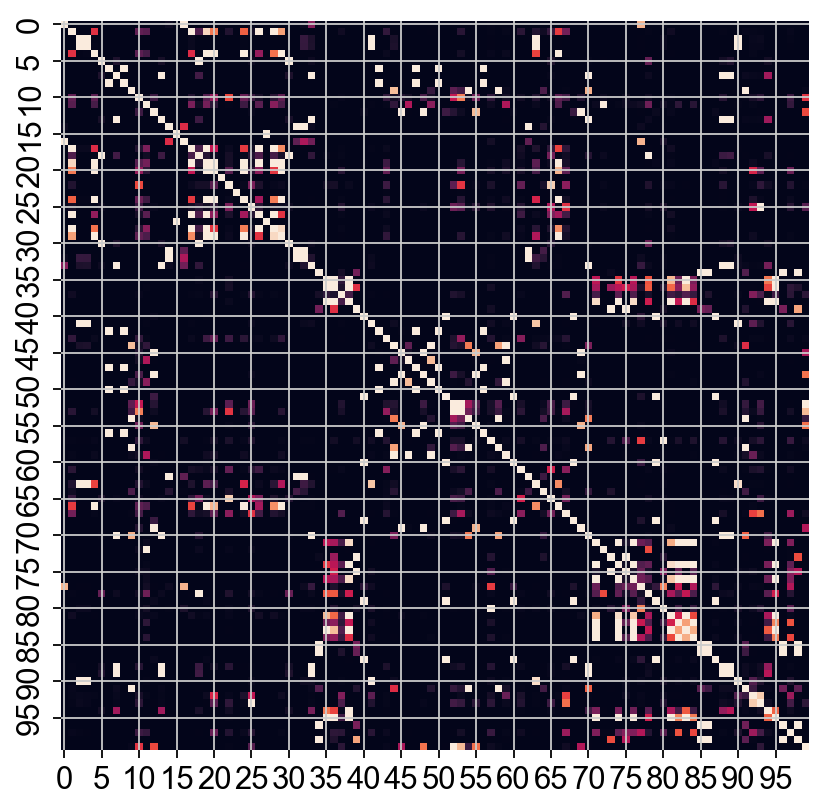

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(norm_cooc_matrix[:100,:100], vmin=0, vmax=0.3, ax=ax, cbar=False)

<Axes: >

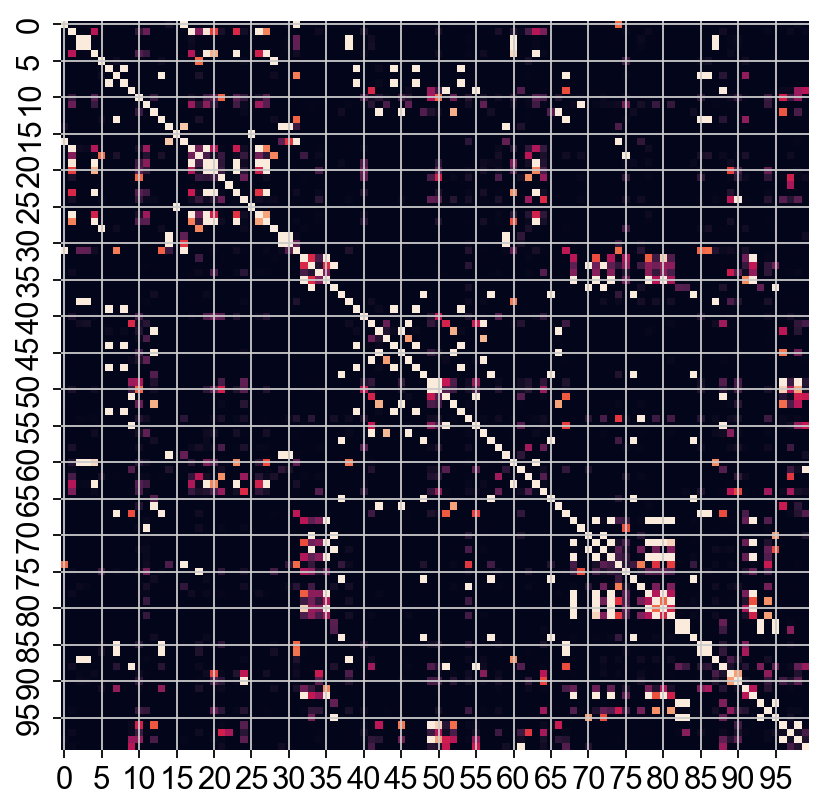

In [10]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(norm_cooc_matrix[:100,:100], vmin=0, vmax=0.3, ax=ax, cbar=False)

In [9]:
norm_cooc_matrix = condensed_cooc_matrix_all.reshape([n_cells, n_cells])/len(clustering_summary)
distance_matrix = 1 - norm_cooc_matrix
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix)

list1 = adata_cluster.obs.target_contrast_gene_name_corrected.values
list2 = adata_cluster.obs.culture_condition.values
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
norm_cooc_matrix_df = pd.DataFrame(data=norm_cooc_matrix,
                                   index=ind,
                                   columns=ind)

In [11]:
norm_cooc_matrix_df.to_csv('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24_cooc_matrix.csv')

In [12]:
norm_cooc_matrix_df = pd.read_csv('../../../RZAnalysisCodes/results/pca_params_screening_nde50ntotal100_varfiltered_neighbor1563resolution24_cooc_matrix.csv', index_col=0)
distance_matrix = 1 - norm_cooc_matrix_df.values
sparse_cooc_matrix = csr_matrix(norm_cooc_matrix_df.values)

In [13]:
norm_cooc_matrix_df

PLAT_Stim8hr  HSPA8_Stim8hr  KLHDC10_Stim8hr  ICOS_Stim8hr  \
PLAT_Stim8hr         0.833333       0.000000         0.000000      0.000000   
HSPA8_Stim8hr        0.000000       0.866667         0.000123      0.000370   
KLHDC10_Stim8hr      0.000000       0.000123         0.876667      0.750988   
ICOS_Stim8hr         0.000000       0.000370         0.750988      0.846667   
ANKRD49_Stim8hr      0.000000       0.170123         0.002099      0.002840   
...                       ...            ...              ...           ...   
SMARCE1_Rest         0.000000       0.009259         0.000000      0.000000   
MYCN_Rest            0.000000       0.000000         0.000000      0.000000   
IRF4_Rest            0.000000       0.000000         0.000000      0.000000   
AASDH_Rest           0.000000       0.000000         0.000000      0.000000   
TM2D1_Rest           0.000000       0.000370         0.209259      0.199753   

                 ANKRD49_Stim8hr  CTU2_Stim8hr  TFAM_Stim48hr  \
PLAT_Stim8hr            0.000000      0.000000            0.0   
HSPA8_Stim8hr           0.170123      0.000741            0.0   
KLHDC10_Stim8hr         0.002099      0.000000            0.0   
ICOS_Stim8hr            0.002840      0.000000            0.0   
ANKRD49_Stim8hr         0.806667      0.000000            0.0   
...                          ...           ...            ...   
SMARCE1_Rest            0.000000      0.000000            0.0   
MYCN_Rest               0.000000      0.005432            0.0   
IRF4_Rest               0.000000      0.000988            0.0   
AASDH_Rest              0.000000      0.000000            0.0   
TM2D1_Rest              0.000000      0.000000            0.0   

                 TMEM131L_Stim48hr  SCO1_Stim48hr  TIMM10_Stim48hr  ...  \
PLAT_Stim8hr              0.000000            0.0          0.00000  ...   
HSPA8_Stim8hr             0.000000            0.0          0.00000  ...   
KLHDC10_Stim8hr           0.000000            0.0          0.00000  ...   
ICOS_Stim8hr              0.000000            0.0          0.00000  ...   
ANKRD49_Stim8hr           0.000000            0.0          0.00000  ...   
...                            ...            ...              ...  ...   
SMARCE1_Rest              0.000617            0.0          0.00358  ...   
MYCN_Rest                 0.000000            0.0          0.00000  ...   
IRF4_Rest                 0.001852            0.0          0.00000  ...   
AASDH_Rest                0.000000            0.0          0.00000  ...   
TM2D1_Rest                0.000370            0.0          0.00000  ...   

                 INSR_Stim8hr  VWF_Stim48hr  RRAGC_Stim48hr  ARL1_Stim48hr  \
PLAT_Stim8hr         0.000000      0.000000             0.0        0.00000   
HSPA8_Stim8hr        0.011975      0.000123             0.0        0.00000   
KLHDC10_Stim8hr      0.000123      0.000000             0.0        0.00000   
ICOS_Stim8hr         0.000247      0.000000             0.0        0.00000   
ANKRD49_Stim8hr      0.000000      0.000000             0.0        0.00000   
...                       ...           ...             ...            ...   
SMARCE1_Rest         0.034691      0.018272             0.0        0.00358   
MYCN_Rest            0.000000      0.000000             0.0        0.00000   
IRF4_Rest            0.000000      0.000000             0.0        0.00000   
AASDH_Rest           0.000000      0.000000             0.0        0.00000   
TM2D1_Rest           0.000000      0.000000             0.0        0.00000   

                 BCL11B_Stim48hr  SMARCE1_Rest  MYCN_Rest  IRF4_Rest  \
PLAT_Stim8hr                 0.0      0.000000   0.000000   0.000000   
HSPA8_Stim8hr                0.0      0.009259   0.000000   0.000000   
KLHDC10_Stim8hr              0.0      0.000000   0.000000   0.000000   
ICOS_Stim8hr                 0.0      0.000000   0.000000   0.000000   
ANKRD49_Stim8hr              0.0      0.000000   0.000000   0.000000   
...              

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


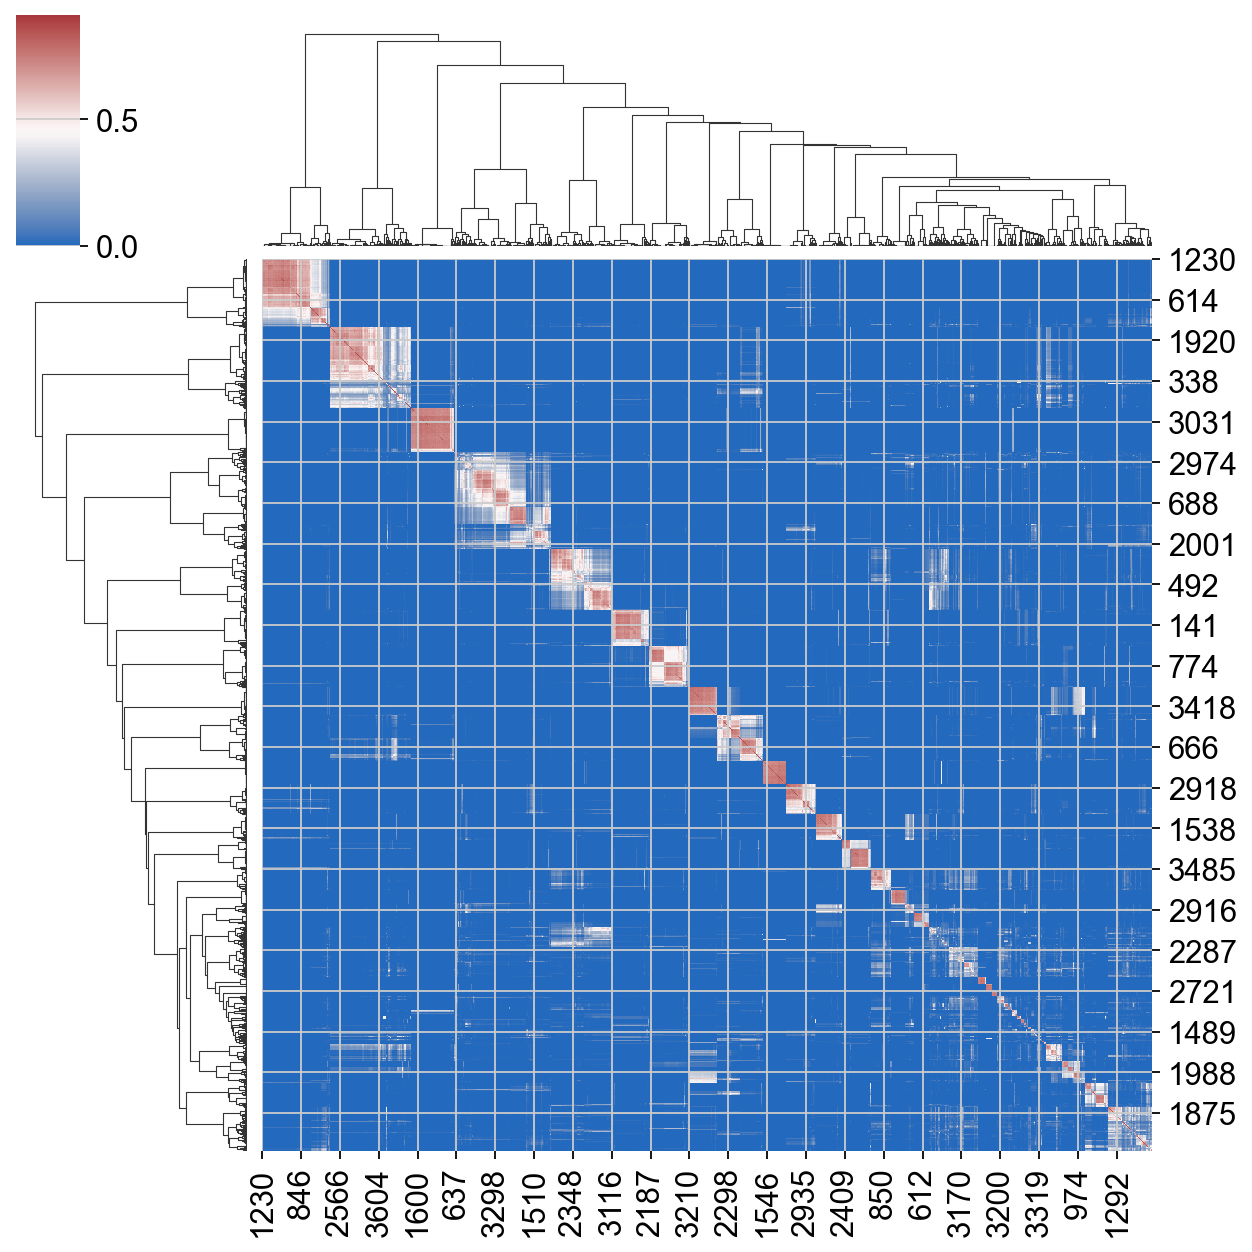

In [12]:
clustermap = sns.clustermap(
    norm_cooc_matrix,
    method='ward', metric='euclidean',
    figsize=(8,8), 
    cmap='vlag'
)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


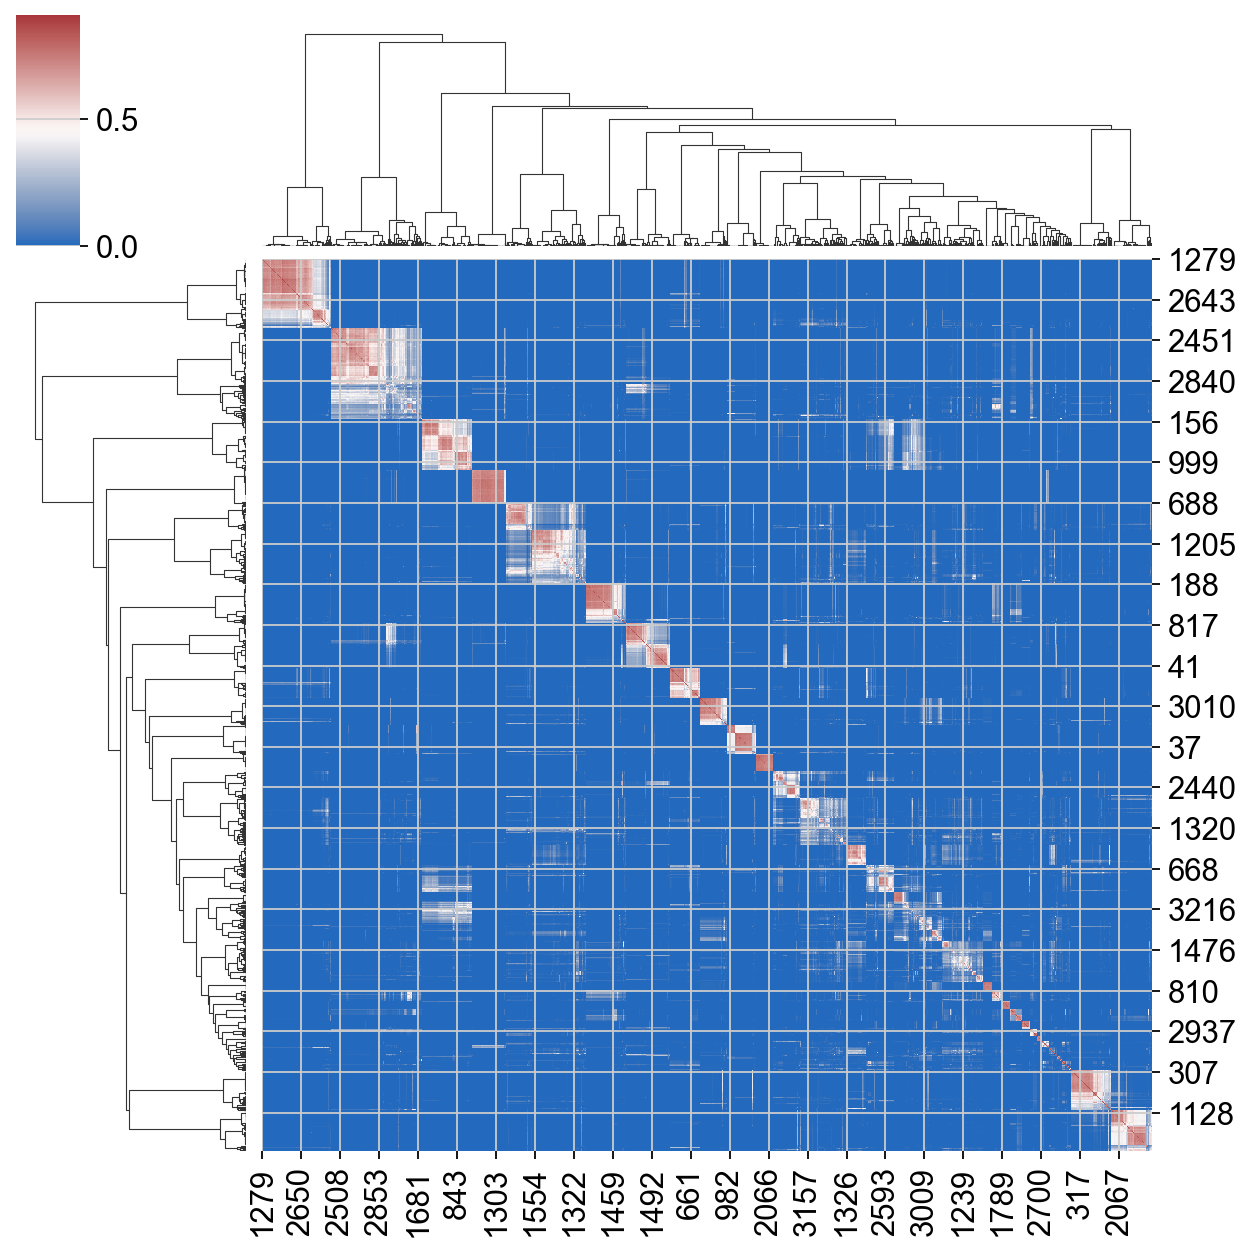

In [12]:
clustermap = sns.clustermap(
    norm_cooc_matrix,
    method='ward', metric='euclidean',
    figsize=(8,8), 
    cmap='vlag'
)

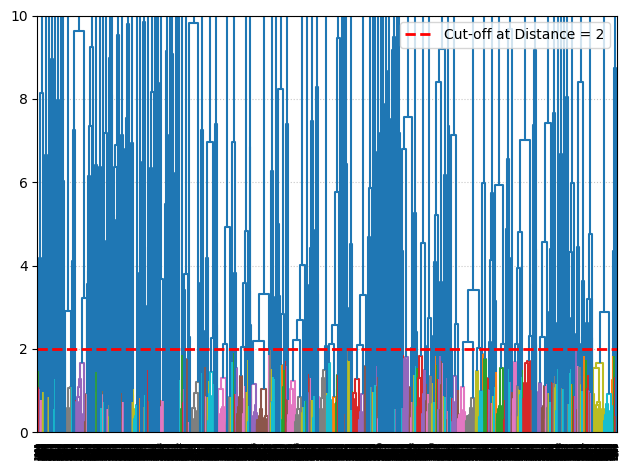

In [11]:
linked = clustermap.dendrogram_row.linkage
cut_off_distance = 2
dendrogram(
    linked,
    orientation='top',
    distance_sort='descending',
    color_threshold = cut_off_distance,
    show_leaf_counts=True,
)
plt.ylim([0,10])
plt.axhline(y=cut_off_distance, color='r', linestyle='--', linewidth=2, label=f'Cut-off at Distance = {cut_off_distance}')
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [74]:
cut_off_distance = 9
linked = linkage(distance_matrix, method='ward')
final_labels = fcluster(linked, t=cut_off_distance, criterion='distance')
adata_cluster.obs['hierarchical'] = final_labels
adata_cluster.obs['hierarchical'] = adata_cluster.obs['hierarchical'].astype('category')

In [75]:
np.sum(adata_cluster.obs['hierarchical'].value_counts()>=4)

99

In [47]:
clusterer = hdbscan.HDBSCAN(metric='precomputed',
                            min_cluster_size=4,
                            min_samples=3,
                            cluster_selection_method='eom')
clusterer.fit(distance_matrix)
final_labels = clusterer.labels_
adata_cluster.obs['hdbscan'] = final_labels
adata_cluster.obs['hdbscan'] = adata_cluster.obs['hdbscan'].astype('category')

In [48]:
adata_cluster.obs['hdbscan'].unique()

[36, 92, 66, 100, 20, ..., 67, 13, 16, 8, 78]
Length: 107
Categories (107, int64): [-1, 0, 1, 2, ..., 102, 103, 104, 105]

In [49]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.str.startswith(('SMG', 'DPH', 'TSC','LAMTOR', 'ELP', 'MED12', 'TAF', 'CD3', 'PTPRC', 'CD28', 'ACLY','INTS'))].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000131473_Stim8hr                       ACLY           Stim8hr   
ENSG00000131473_Stim48hr                      ACLY          Stim48hr   
ENSG00000178562_Stim48hr                      CD28          Stim48hr   
ENSG00000178562_Stim8hr                       CD28           Stim8hr   
ENSG00000167286_Stim8hr                       CD3D           Stim8hr   
ENSG00000198851_Stim8hr                       CD3E           Stim8hr   
ENSG00000160654_Stim8hr                       CD3G           Stim8hr   
ENSG00000160654_Stim48hr                      CD3G          Stim48hr   
ENSG00000108963_Stim8hr                       DPH1           Stim8hr   
ENSG00000108963_Rest                          DPH1              Rest   
ENSG00000108963_Stim48hr                      DPH1          Stim48hr   
ENSG00000132768_Rest                          DPH2              Rest   
ENSG00000132768_Stim48hr                      DPH2          Stim48hr   
ENSG00000117543_Rest                          DPH5              Rest   
ENSG00000117543_Stim8hr                       DPH5           Stim8hr   
ENSG00000117543_Stim48hr                      DPH5          Stim48hr   
ENSG00000134146_Stim8hr                       DPH6           Stim8hr   
ENSG00000134146_Stim48hr                      DPH6          Stim48hr   
ENSG00000070061_Stim8hr                       ELP1           Stim8hr   
ENSG00000070061_Rest                          ELP1              Rest   
ENSG00000070061_Stim48hr                      ELP1          Stim48hr   
ENSG00000134759_Stim48hr                      ELP2          Stim48hr   
ENSG00000134759_Stim8hr                       ELP2           Stim8hr   
ENSG00000134759_Rest                          ELP2              Rest   
ENSG00000134014_Rest                          ELP3              Rest   
ENSG00000134014_Stim8hr                       ELP3           Stim8hr   
ENSG00000134014_Stim48hr                      ELP3          Stim48hr   
ENSG00000109911_Rest                          ELP4              Rest   
ENSG00000109911_Stim8hr                       ELP4           Stim8hr   
ENSG00000109911_Stim48hr                      ELP4          Stim48hr   
ENSG00000170291_Stim8hr                       ELP5           Stim8hr   
ENSG00000170291_Stim48hr                      ELP5          Stim48hr   
ENSG00000170291_Rest                          ELP5              Rest   
ENSG00000163832_Rest                          ELP6              Rest   
ENSG00000163832_Stim8hr                       ELP6           Stim8hr   
ENSG00000104613_Stim8hr                     INTS10           Stim8hr   
ENSG00000104613_Rest                        INTS10              Rest   
ENSG00000104613_Stim48hr                    INTS10          Stim48hr   
ENSG00000138785_Stim48hr                    INTS12          Stim48hr   
ENSG00000138785_Rest                        INTS12              Rest   
ENSG00000138785_Stim8hr                     INTS12           Stim8hr   
ENSG00000064102_Stim8hr                     INTS13           Stim8hr   
ENSG00000064102_Stim48hr                    INTS13          Stim48hr   
ENSG00000064102_Rest                        INTS13              Rest   
ENSG00000138614_Stim48hr                    INTS14          Stim48hr   
ENSG00000138614_Rest                        INTS14              Rest   
ENSG00000138614_Stim8hr                     INTS14           Stim8hr   
ENSG00000146576_Stim8hr                    C7orf26           Stim8hr   
ENSG00000146576_Stim48hr                   C7orf26          Stim48hr   
ENSG00000102786_Stim48hr                     INTS6          Stim48hr   
ENSG00000102786_Rest                         INTS6              Rest   
ENSG00000116586_Stim8hr                    LAMTOR2           Stim8hr   
ENSG00000116586_Rest                       LAMTOR2              Rest   
ENSG00000116586_Stim48hr                   LAMTOR2          Stim48hr   
ENSG00000109270_Rest                       LAMTOR3              R

In [43]:
testlist = ['AQP1','CD69','ENKUR','PTPN2','IL21R','IRF1','MBD2','MAPK9','ARRDC4','PSMF1','RSBN1L','SELL','SMAGP','THAP2','TRAF3','XRRA1','LAT2','MTA2','ELOB','WAS','FBRS','MEN1','ATP2A2','MEAF6','TMED9']

In [44]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.isin(testlist)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000140450_Rest                        ARRDC4              Rest   
ENSG00000140450_Stim48hr                    ARRDC4          Stim48hr   
ENSG00000140450_Stim8hr                     ARRDC4           Stim8hr   
ENSG00000174437_Rest                        ATP2A2              Rest   
ENSG00000174437_Stim48hr                    ATP2A2          Stim48hr   
ENSG00000174437_Stim8hr                     ATP2A2           Stim8hr   
ENSG00000103363_Rest                          ELOB              Rest   
ENSG00000103363_Stim48hr                      ELOB          Stim48hr   
ENSG00000103363_Stim8hr                       ELOB           Stim8hr   
ENSG00000156860_Stim48hr                      FBRS          Stim48hr   
ENSG00000156860_Stim8hr                       FBRS           Stim8hr   
ENSG00000103522_Stim48hr                     IL21R          Stim48hr   
ENSG00000103522_Stim8hr                      IL21R           Stim8hr   
ENSG00000125347_Stim8hr                       IRF1           Stim8hr   
ENSG00000125347_Stim48hr                      IRF1          Stim48hr   
ENSG00000125347_Rest                          IRF1              Rest   
ENSG00000086730_Stim48hr                      LAT2          Stim48hr   
ENSG00000086730_Rest                          LAT2              Rest   
ENSG00000086730_Stim8hr                       LAT2           Stim8hr   
ENSG00000133895_Stim48hr                      MEN1          Stim48hr   
ENSG00000133895_Rest                          MEN1              Rest   
ENSG00000133895_Stim8hr                       MEN1           Stim8hr   
ENSG00000149480_Stim48hr                      MTA2          Stim48hr   
ENSG00000149480_Rest                          MTA2              Rest   
ENSG00000149480_Stim8hr                       MTA2           Stim8hr   
ENSG00000125818_Stim48hr                     PSMF1          Stim48hr   
ENSG00000125818_Stim8hr                      PSMF1           Stim8hr   
ENSG00000125818_Rest                         PSMF1              Rest   
ENSG00000175354_Rest                         PTPN2              Rest   
ENSG00000175354_Stim48hr                     PTPN2          Stim48hr   
ENSG00000175354_Stim8hr                      PTPN2           Stim8hr   
ENSG00000187257_Stim8hr                     RSBN1L           Stim8hr   
ENSG00000170545_Rest                         SMAGP              Rest   
ENSG00000173451_Rest                         THAP2              Rest   
ENSG00000173451_Stim48hr                     THAP2          Stim48hr   
ENSG00000173451_Stim8hr                      THAP2           Stim8hr   
ENSG00000184840_Stim8hr                      TMED9           Stim8hr   
ENSG00000184840_Stim48hr                     TMED9          Stim48hr   
ENSG00000184840_Rest                         TMED9              Rest   
ENSG00000131323_Rest                         TRAF3              Rest   
ENSG00000131323_Stim8hr                      TRAF3           Stim8hr   
ENSG00000131323_Stim48hr                     TRAF3          Stim48hr   
ENSG00000015285_Stim8hr                        WAS           Stim8hr   
ENSG00000166435_Rest                         XRRA1              Rest   
ENSG00000166435_Stim48hr                     XRRA1          Stim48hr   
ENSG00000166435_Stim8hr                      XRRA1           Stim8hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000140450_Rest      ENSG00000140450    13           124.0   
ENSG00000140450_Stim48hr  ENSG00000140450   411           120.0   
ENSG00000140450_Stim8hr   ENSG00000140450   274           105.0   
ENSG00000174437_Rest      ENSG00000174437   522           268.0   
ENSG00000174437_Stim48hr  ENSG00000174437   528           107.0   
ENSG00000174437_Stim8hr   ENSG00000174437   574           248.0   
ENSG00000103363_Rest      ENSG00000103363   532           983.0   
ENSG00000103363_Stim48hr  ENSG00000103363   270           762.0   
ENSG00000103363_Stim8hr   ENSG0000010

In [50]:
testlist = ['ARHGAP27', 'CDK2', 'PRKCQ', 'TXNDC9', 'COG6', 'SIK3', 'IKZF1', 'PKN3', 'HTT', 'NUSAP1', 'PDCD5', 'STAT5A', 'ICE2', 'MYO9A', 'KAT2B', 'FOXO1', 'PIBF1', 'CD28', 'PTPRC', 'PPCDC']

In [51]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.isin(testlist)].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000159314_Stim8hr                   ARHGAP27           Stim8hr   
ENSG00000159314_Stim48hr                  ARHGAP27          Stim48hr   
ENSG00000178562_Stim8hr                       CD28           Stim8hr   
ENSG00000178562_Stim48hr                      CD28          Stim48hr   
ENSG00000123374_Stim8hr                       CDK2           Stim8hr   
ENSG00000123374_Stim48hr                      CDK2          Stim48hr   
ENSG00000133103_Stim48hr                      COG6          Stim48hr   
ENSG00000133103_Stim8hr                       COG6           Stim8hr   
ENSG00000133103_Rest                          COG6              Rest   
ENSG00000150907_Stim48hr                     FOXO1          Stim48hr   
ENSG00000150907_Rest                         FOXO1              Rest   
ENSG00000150907_Stim8hr                      FOXO1           Stim8hr   
ENSG00000197386_Stim48hr                       HTT          Stim48hr   
ENSG00000128915_Stim48hr                      ICE2          Stim48hr   
ENSG00000185811_Stim8hr                      IKZF1           Stim8hr   
ENSG00000066933_Stim8hr                      MYO9A           Stim8hr   
ENSG00000066933_Rest                         MYO9A              Rest   
ENSG00000066933_Stim48hr                     MYO9A          Stim48hr   
ENSG00000105185_Stim48hr                     PDCD5          Stim48hr   
ENSG00000083535_Stim48hr                     PIBF1          Stim48hr   
ENSG00000083535_Stim8hr                      PIBF1           Stim8hr   
ENSG00000160447_Stim48hr                      PKN3          Stim48hr   
ENSG00000138621_Stim8hr                      PPCDC           Stim8hr   
ENSG00000138621_Rest                         PPCDC              Rest   
ENSG00000138621_Stim48hr                     PPCDC          Stim48hr   
ENSG00000065675_Stim48hr                     PRKCQ          Stim48hr   
ENSG00000081237_Stim48hr                     PTPRC          Stim48hr   
ENSG00000081237_Stim8hr                      PTPRC           Stim8hr   
ENSG00000081237_Rest                         PTPRC              Rest   
ENSG00000160584_Rest                          SIK3              Rest   
ENSG00000160584_Stim48hr                      SIK3          Stim48hr   
ENSG00000160584_Stim8hr                       SIK3           Stim8hr   
ENSG00000126561_Stim48hr                    STAT5A          Stim48hr   
ENSG00000115514_Stim8hr                     TXNDC9           Stim8hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000159314_Stim8hr   ENSG00000159314   604           234.0   
ENSG00000159314_Stim48hr  ENSG00000159314   145           201.0   
ENSG00000178562_Stim8hr   ENSG00000178562    99           675.0   
ENSG00000178562_Stim48hr  ENSG00000178562   401           514.0   
ENSG00000123374_Stim8hr   ENSG00000123374   516           612.0   
ENSG00000123374_Stim48hr  ENSG00000123374   297           598.0   
ENSG00000133103_Stim48hr  ENSG00000133103   663           110.0   
ENSG00000133103_Stim8hr   ENSG00000133103   657           159.0   
ENSG00000133103_Rest      ENSG00000133103   236           161.0   
ENSG00000150907_Stim48hr  ENSG00000150907   489           901.0   
ENSG00000150907_Rest      ENSG00000150907   459           679.0   
ENSG00000150907_Stim8hr   ENSG00000150907   339           723.0   
ENSG00000197386_Stim48hr  ENSG00000197386   441          1211.0   
ENSG00000128915_Stim48hr  ENSG00000128915   314           534.0   
ENSG00000185811_Stim8hr   ENSG00000185811   164           621.0   
ENSG00000066933_Stim8hr   ENSG00000066933   292           891.0   
ENSG00000066933_Rest      ENSG00000066933   357          1022.0   
ENSG00000066933_Stim48hr  ENSG00000066933   655           921.0   
ENSG00000105185_Stim48hr  ENSG00000105185   587           385.0   
ENSG00000083535_Stim48hr  ENSG00000083535   450           301.0   
ENSG00000083535_Stim8hr   ENSG00000083535   157           259.0   
ENSG00000160447_Stim48hr  ENSG

In [27]:
de_summary_stats[de_summary_stats.target_name=='PPCS']

target_contrast target_name condition  n_cells_target  n_up_genes  \
2072   ENSG00000127125        PPCS      Rest           137.0         523   
4872   ENSG00000127125        PPCS   Stim8hr           138.0         492   
11952  ENSG00000127125        PPCS  Stim48hr            52.0         145   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2072            153               676             -3.932838   
4872            300               792             -5.133298   
11952            24               169             -1.067717   

       ontarget_significant   baseMean  offtarget_flag n_total_genes_category  \
2072                   True  20.314772           False           >10 DE genes   
4872                   True  26.464996           False           >10 DE genes   
11952                 False  28.424935           False           >10 DE genes   

      ontarget_effect_category target_contrast_corrected  \
2072              on-target KD           ENSG00000127125   
4872              on-target KD           ENSG00000127125   
11952          no on-target KD           ENSG00000127125   

                      obs_names target_name_corrected  
2072       ENSG00000127125_Rest                  PPCS  
4872    ENSG00000127125_Stim8hr                  PPCS  
11952  ENSG00000127125_Stim48hr                  PPCS

In [54]:
adata_cluster[adata_cluster.obs.hdbscan==25].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000131473_Stim48hr                      ACLY          Stim48hr   
ENSG00000062485_Stim48hr                        CS          Stim48hr   
ENSG00000150768_Stim48hr                      DLAT          Stim48hr   
ENSG00000146701_Stim48hr                      MDH2          Stim48hr   
ENSG00000131828_Stim48hr                     PDHA1          Stim48hr   
ENSG00000168291_Stim48hr                      PDHB          Stim48hr   
ENSG00000100075_Stim48hr                   SLC25A1          Stim48hr   
ENSG00000127952_Stim48hr                    STYXL1          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000131473_Stim48hr  ENSG00000131473   570           282.0   
ENSG00000062485_Stim48hr  ENSG00000062485   469           232.0   
ENSG00000150768_Stim48hr  ENSG00000150768   392           372.0   
ENSG00000146701_Stim48hr  ENSG00000146701   182           998.0   
ENSG00000131828_Stim48hr  ENSG00000131828   454           192.0   
ENSG00000168291_Stim48hr  ENSG00000168291   155           303.0   
ENSG00000100075_Stim48hr  ENSG00000100075   102           521.0   
ENSG00000127952_Stim48hr  ENSG00000127952   671           753.0   

                         target_contrast_corrected  \
ENSG00000131473_Stim48hr           ENSG00000131473   
ENSG00000062485_Stim48hr           ENSG00000062485   
ENSG00000150768_Stim48hr           ENSG00000150768   
ENSG00000146701_Stim48hr           ENSG00000146701   
ENSG00000131828_Stim48hr           ENSG00000131828   
ENSG00000168291_Stim48hr           ENSG00000168291   
ENSG00000100075_Stim48hr           ENSG00000100075   
ENSG00000127952_Stim48hr           ENSG00000127952   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000131473_Stim48hr                                ACLY      25  
ENSG00000062485_Stim48hr                                  CS      25  
ENSG00000150768_Stim48hr                                DLAT      25  
ENSG00000146701_Stim48hr                                MDH2      25  
ENSG00000131828_Stim48hr                               PDHA1      25  
ENSG00000168291_Stim48hr                                PDHB      25  
ENSG00000100075_Stim48hr                             SLC25A1      25  
ENSG00000127952_Stim48hr                              STYXL1      25

In [ ]:
adata_cluster[adata_cluster.obs.hdbscan==12].obs.target_contrast_gene_name_corrected.tolist()

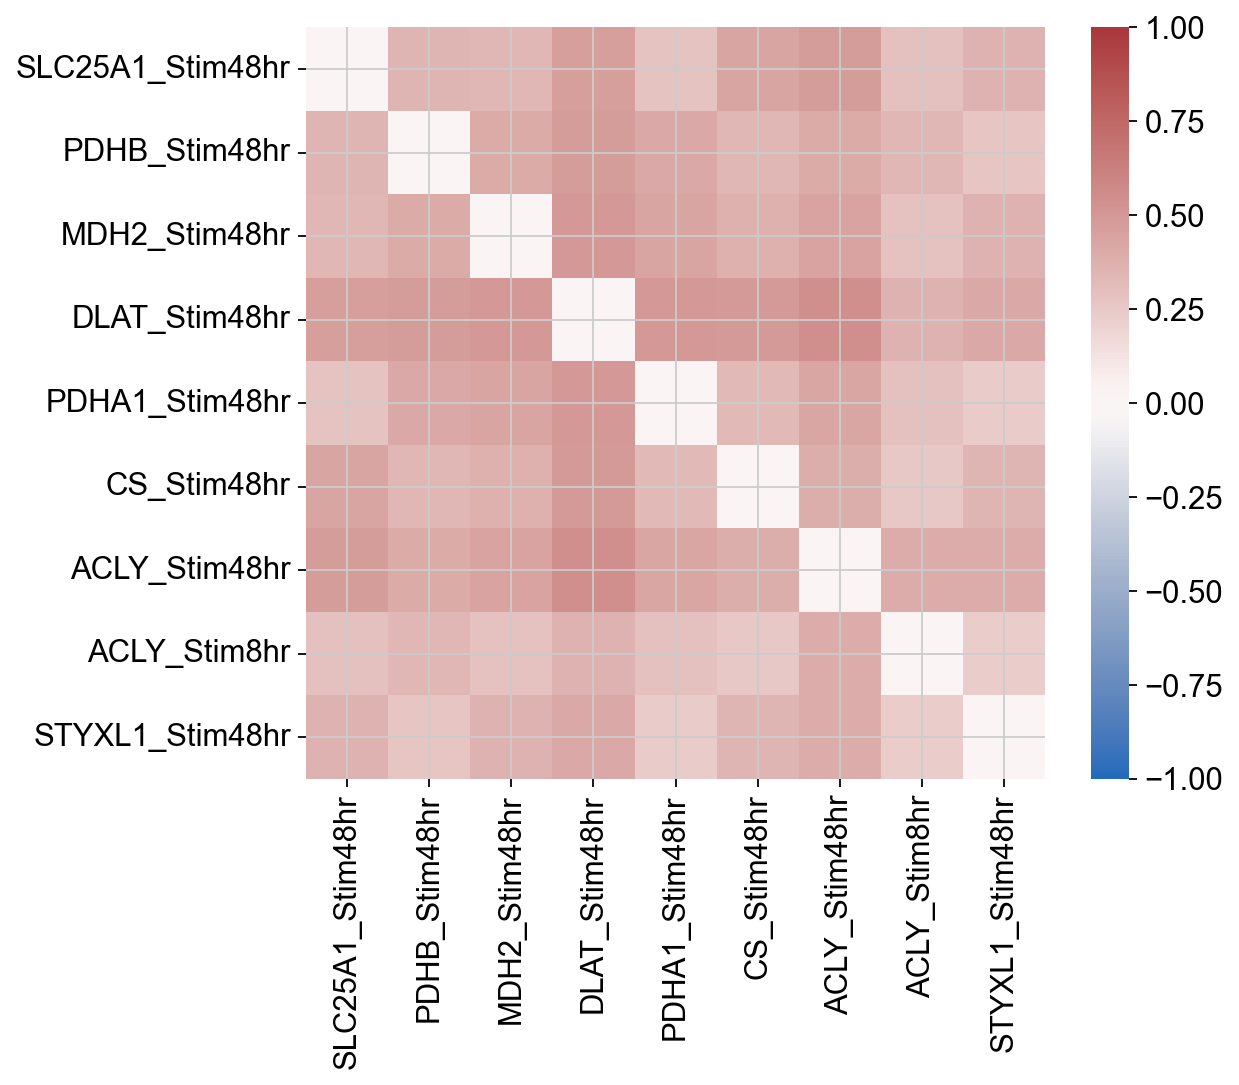

In [78]:
fig, ax = plt.subplots(figsize=(8,7))
cluster_label = 'hdbscan'
j = 32
data = adata_cluster[adata_cluster.obs[cluster_label]==j].X
list1 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.target_contrast_gene_name_corrected.values.tolist()
list2 = adata_cluster[adata_cluster.obs[cluster_label]==j].obs.culture_condition.values.tolist()
ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
for i in range(j,32):
    data = np.concatenate([data, adata_cluster[adata_cluster.obs[cluster_label]==i+1].X])
    list1 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.target_contrast_gene_name.values.tolist()
    list2 = adata_cluster[adata_cluster.obs[cluster_label]==i+1].obs.culture_condition.values.tolist()
    ind = ind +[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
test = pd.DataFrame(data=data,
                    index=ind,
                    columns=adata_cluster.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, vmin=-1, vmax=1, cmap='vlag', ax=ax)
plt.tight_layout()

### Filter out low quality hdbscan clusters

In [55]:
np.max(adata_cluster.obs['hdbscan'].astype(int))

105

In [56]:
num_of_cluster = np.max(adata_cluster.obs['hdbscan'].astype(int))+1
corr = np.zeros(num_of_cluster)
cluster_size = np.zeros(num_of_cluster)
cluster_gene_size = np.zeros(num_of_cluster)
cluster_member = []
for i in range(len(corr)):
    list1 = adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata_cluster[adata_cluster.obs['hdbscan']==i].obs.culture_condition.values.tolist()
    test = pd.DataFrame(data=adata_cluster[adata_cluster.obs['hdbscan']==i].layers['zscore'],
                        index=[f"{item1}_{item2}" for item1, item2 in zip(list1, list2)],
                        columns=adata_cluster.var.gene_name)
    test2 = test.T.corr()
    np.fill_diagonal(test2.values, 0)
    corr[i] = np.mean(test2)
    cluster_size[i] = len(test)
    cluster_gene_size[i] = len(adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique())
    cluster_member.append(adata_cluster[adata_cluster.obs['hdbscan']==i].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': np.arange(0, num_of_cluster, 1),
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

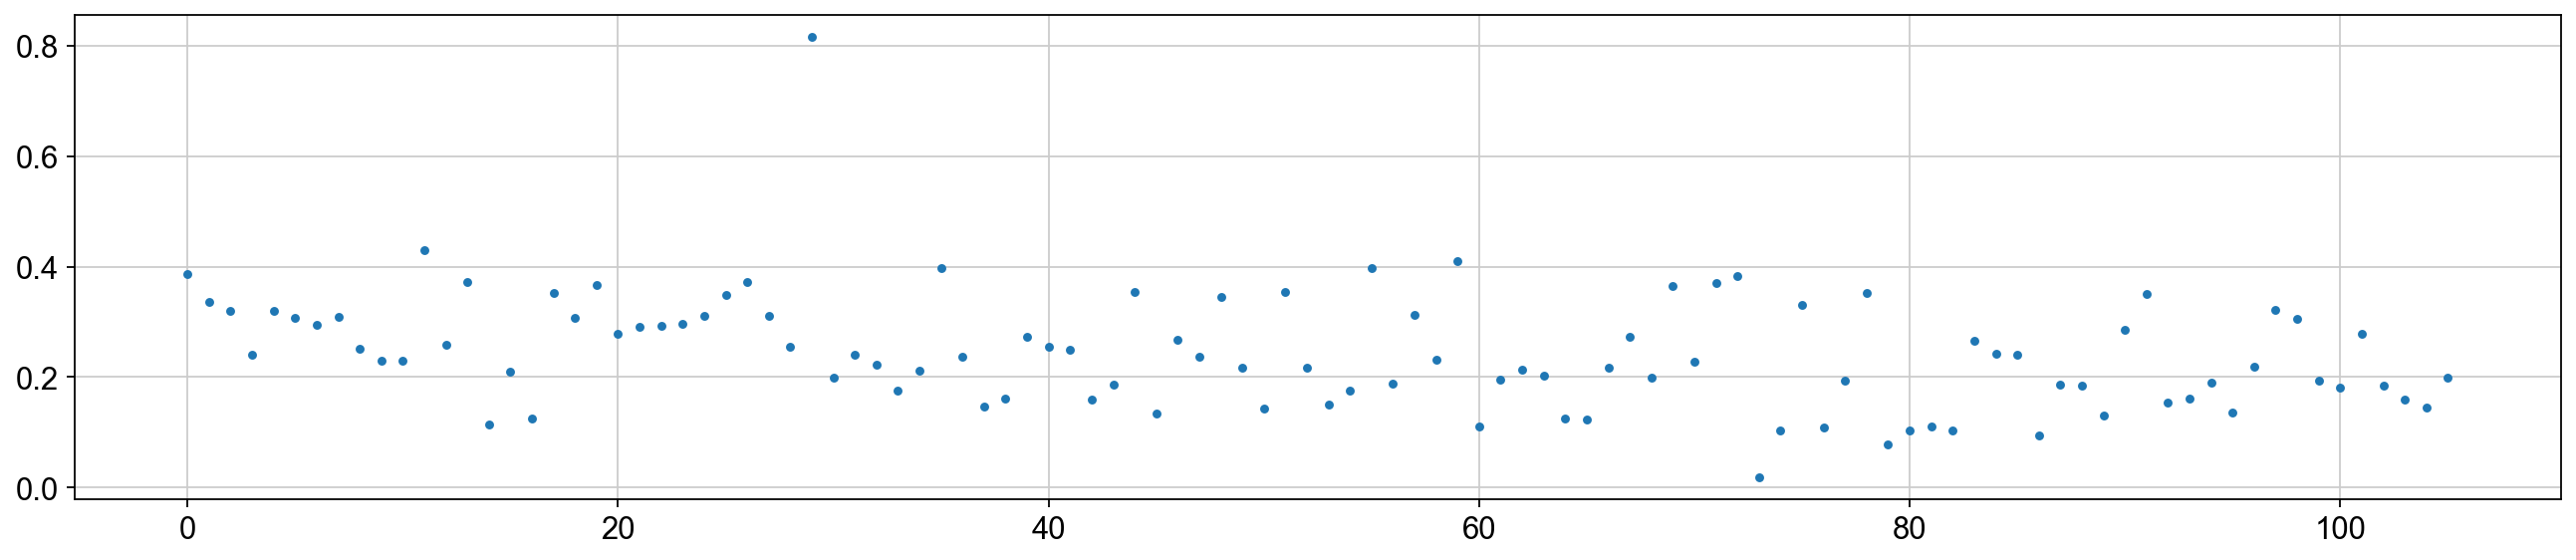

In [57]:
plt.plot(cluster_df.intracluster_corr, '.')

In [58]:
adata_final = adata_cluster.copy()
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(np.where(cluster_df.intracluster_corr<0.2)[0]), 'hdbscan'] = -1
adata_final.obs.loc[adata_final.obs['hdbscan'].isin(np.where(cluster_gene_size<3)[0]), 'hdbscan'] = -1
adata_final.obs['hdbscan'] = adata_final.obs['hdbscan'].astype('category')
adata_final = adata_final[adata_final.obs.hdbscan!=-1].copy()

In [59]:
adata_final.obs

target_contrast_gene_name culture_condition  \
ENSG00000104368_Stim8hr                       PLAT           Stim8hr   
ENSG00000128607_Stim8hr                    KLHDC10           Stim8hr   
ENSG00000163600_Stim8hr                       ICOS           Stim8hr   
ENSG00000174177_Stim8hr                       CTU2           Stim8hr   
ENSG00000108064_Stim48hr                      TFAM          Stim48hr   
...                                            ...               ...   
ENSG00000127152_Stim48hr                    BCL11B          Stim48hr   
ENSG00000134323_Rest                          MYCN              Rest   
ENSG00000137265_Rest                          MUM1              Rest   
ENSG00000157426_Rest                         AASDH              Rest   
ENSG00000162604_Rest                         TM2D1              Rest   

                          target_contrast chunk  n_cells_target  \
ENSG00000104368_Stim8hr   ENSG00000104368     0           411.0   
ENSG00000128607_Stim8hr   ENSG00000128607     0          1257.0   
ENSG00000163600_Stim8hr   ENSG00000163600     0           658.0   
ENSG00000174177_Stim8hr   ENSG00000174177     0           500.0   
ENSG00000108064_Stim48hr  ENSG00000108064     1           414.0   
...                                   ...   ...             ...   
ENSG00000127152_Stim48hr  ENSG00000127152   679           203.0   
ENSG00000134323_Rest      ENSG00000134323   680           924.0   
ENSG00000137265_Rest      ENSG00000137265   680           803.0   
ENSG00000157426_Rest      ENSG00000157426   680           651.0   
ENSG00000162604_Rest      ENSG00000162604   680           717.0   

                         target_contrast_corrected  \
ENSG00000104368_Stim8hr            ENSG00000104368   
ENSG00000128607_Stim8hr            ENSG00000128607   
ENSG00000163600_Stim8hr            ENSG00000163600   
ENSG00000174177_Stim8hr            ENSG00000174177   
ENSG00000108064_Stim48hr           ENSG00000108064   
...                                            ...   
ENSG00000127152_Stim48hr           ENSG00000127152   
ENSG00000134323_Rest               ENSG00000134323   
ENSG00000137265_Rest               ENSG00000137265   
ENSG00000157426_Rest               ENSG00000157426   
ENSG00000162604_Rest               ENSG00000162604   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000104368_Stim8hr                                 PLAT      36  
ENSG00000128607_Stim8hr                              KLHDC10      66  
ENSG00000163600_Stim8hr                                 ICOS      66  
ENSG00000174177_Stim8hr                                 CTU2      20  
ENSG00000108064_Stim48hr                                TFAM      71  
...                                                      ...     ...  
ENSG00000127152_Stim48hr                              BCL11B     101  
ENSG00000134323_Rest                                    MYCN      21  
ENSG00000137265_Rest                                    IRF4      90  
ENSG00000157426_Rest                                   AASDH      91  
ENSG00000162604_Rest                                   TM2D1      63  

[1959 rows x 8 columns]

In [60]:
len(adata_final.obs['hdbscan'].unique())

55

In [61]:
adata_final.obs.target_contrast_gene_name.unique()

['PLAT', 'KLHDC10', 'ICOS', 'CTU2', 'TFAM', ..., 'TYK2', 'TRMT6', 'VWF', 'ARL1', 'BCL11B']
Length: 1354
Categories (1354, object): ['A2M', 'AASDH', 'ABCA3', 'ABCC1', ..., 'ZSCAN25', 'ZSWIM4', 'ZSWIM9', 'ZW10']

In [62]:
import gseapy
from gseapy import Msigdb
from gseapy import barplot, dotplot

msig = Msigdb()
kegg_gene_sets = msig.get_gmt(category= 'c2.cp.kegg_legacy', dbver="2025.1.Hs")
reactome_gene_sets = msig.get_gmt(category= 'c2.cp.reactome', dbver="2025.1.Hs")

In [63]:
corum_df = pd.read_csv('../../../RZAnalysisCodes/results/CORUM/corum_humanComplexes.txt', delimiter='\t', index_col='complex_id')
stringdb = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.clusters.proteins.v12.0.txt.gz', delimiter='\t', compression='gzip')
protein_info = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.protein.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
cluster_info = pd.read_csv('../../../RZAnalysisCodes/results/STRINGDB/9606.clusters.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
stringdb_df = pd.merge(stringdb, protein_info, left_on='protein_id', right_on='#string_protein_id')
stringdb_df = pd.merge(stringdb_df, cluster_info, left_on='cluster_id', right_on='cluster_id')
stringdb_df = stringdb_df[stringdb_df.cluster_size<1000].copy()

corum_complexes = {}
for _, row in corum_df.iterrows():
    complex_name = row['complex_name']
    subunits = set(row['subunits_gene_name'].split(';'))
    corum_complexes[complex_name] = subunits

stringdb_complexes = {}
for cluster_id in stringdb_df.cluster_id.unique():
    stringdb_complexes[cluster_id] = set(stringdb_df[stringdb_df.cluster_id==cluster_id].preferred_name)

In [64]:
def assess_complex_enrichment(adata, complexes, cluster_label):
    """
    Assess pathway/complex enrichment
    """
    de_genes_per_cluster = {}
    leiden_clusters = adata.obs[cluster_label].unique()
    for cluster in leiden_clusters:
        cluster_genes = adata[adata.obs[cluster_label] == cluster].obs.target_contrast_gene_name_corrected
        de_genes_per_cluster[cluster] = set(cluster_genes)
    
    N = len(adata)
    
    best_result = []
    all_result = []
    for cluster, de_genes in de_genes_per_cluster.items():
        n = len(de_genes)
        best_result_for_cluster = None # Initialize a variable to track the best result for this cluster
        for complex_name, subunits in complexes.items():
            K = len(subunits)
            # Find the overlap between DE genes and complex subunits
            overlap = de_genes.intersection(subunits)
            k = len(overlap)
            
            # Calculate the p-value
            if n > 0 and K > 0: # Avoid division by zero or trivial cases
                pval = hypergeom.sf(k - 1, N, K, n) # sf is survival function
                
                # Adjust for multiple testing (e.g., using Benjamini-Hochberg)
                # This is a crucial step to avoid false positives
                # Store raw p-values and correct later
                current_result = {
                    'cluster': cluster,
                    'complex': complex_name,
                    'overlap_genes': list(overlap),
                    'overlap_fraction': len(overlap)/n,
                    'raw_p_value': pval,
                    'complex_size': K
                }
                
                if (best_result_for_cluster is None) or (pval < best_result_for_cluster['raw_p_value']):
                    best_result_for_cluster = current_result
                if pval < 5e-2:
                    all_result.append(current_result)
        
        if best_result_for_cluster is not None:
            if best_result_for_cluster['raw_p_value']<1:
                best_result.append(best_result_for_cluster)
    
    # Convert results to a DataFrame for easy viewing
    best_result_df = pd.DataFrame(best_result)
    best_result_df = best_result_df.sort_values(by='cluster').reset_index(drop=True)
    all_result_df = pd.DataFrame(all_result)
    all_result_df = all_result_df.sort_values(by='cluster').reset_index(drop=True)

    return all_result_df, best_result_df

In [65]:
# STRINGDB enrichment
stringdb_enrichment_all, stringdb_enrichment_best = assess_complex_enrichment(adata_final, stringdb_complexes, 'hdbscan')
stringdb_enrichment_all = pd.merge(stringdb_enrichment_all, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
stringdb_enrichment_all = stringdb_enrichment_all.drop(columns=['cluster_id'])
stringdb_enrichment_best = pd.merge(stringdb_enrichment_best, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
stringdb_enrichment_best = stringdb_enrichment_best.drop(columns=['cluster_id'])
# Corum enrichment
corum_enrichment_all, corum_enrichment_best = assess_complex_enrichment(adata_final, corum_complexes, 'hdbscan')
# KEGG enrichment
kegg_enrichment_all, kegg_enrichment_best = assess_complex_enrichment(adata_final, kegg_gene_sets, 'hdbscan')
# Reactome enrichment
reactome_enrichment_all, reactome_enrichment_best = assess_complex_enrichment(adata_final, reactome_gene_sets, 'hdbscan')

# Also checking inter-cluster overlap
gene_grouping = {}
for cluster in adata_final.obs.hdbscan.unique():
    gene_grouping[cluster] = set(adata_final[adata_final.obs['hdbscan']==cluster].obs.target_contrast_gene_name_corrected)

intercluster_enrichment_all, _ = assess_complex_enrichment(adata_final, gene_grouping, 'hdbscan')
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.cluster!=intercluster_enrichment_all.complex].copy()
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.raw_p_value<1e-2].copy()
intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.overlap_fraction>=0.2].copy()
intercluster_enrichment_summary = {}

for cluster in intercluster_enrichment_all.cluster.unique():
    intercluster_enrichment_summary[cluster] = set(intercluster_enrichment_all[intercluster_enrichment_all.cluster==cluster].complex)

intercluster_enrichment_summary_df = pd.DataFrame(intercluster_enrichment_summary.items(), columns=['cluster', 'related_cluster'])

# Summarize results
enrichment_df1 = pd.merge(corum_enrichment_best, stringdb_enrichment_best, on='cluster', how='outer', suffixes=('_corum', '_stringdb'))
enrichment_df2 = pd.merge(kegg_enrichment_best, reactome_enrichment_best, on='cluster', how='outer', suffixes=('_kegg', '_reactome'))
enrichment_df = pd.merge(enrichment_df1, enrichment_df2, on='cluster', how='outer')
enrichment_df = pd.merge(enrichment_df, cluster_df, on='cluster', how='inner')
enrichment_df = pd.merge(enrichment_df, intercluster_enrichment_summary_df, on='cluster', how='outer')

# Add timepoint information
cluster_member_with_condition = []
for index, row in enrichment_df.iterrows():
    list1 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.target_contrast_gene_name_corrected.tolist()
    list2 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.culture_condition.tolist()
    cluster_member_with_condition.append([f"{item1}_{item2}" for item1, item2 in zip(list1, list2)])
    enrichment_df.loc[index, 'rest_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Rest')])
    enrichment_df.loc[index, 'stim8hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim8hr')])
    enrichment_df.loc[index, 'stim48hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim48hr')])
    
enrichment_df['cluster_member_with_condition'] = cluster_member_with_condition

In [66]:
enrichment_df.to_parquet('results/clustering_nde50ntotal100.parquet')
enrichment_df.to_csv('results/clustering_nde50ntotal100.csv')
corum_enrichment_all.to_parquet('results/corum_enrichment_nde50ntotal100.parquet')
corum_enrichment_all.to_csv('results/corum_enrichment_nde50ntotal100.csv')
stringdb_enrichment_all.to_parquet('results/stringdb_enrichment_nde50ntotal100.parquet')
stringdb_enrichment_all.to_csv('results/stringdb_enrichment_nde50ntotal100.csv')
kegg_enrichment_all.to_parquet('results/kegg_enrichment_nde50ntotal100.parquet')
kegg_enrichment_all.to_csv('results/kegg_enrichment_nde50ntotal100.csv')
reactome_enrichment_all.to_parquet('results/reactome_enrichment_nde50ntotal100.parquet')
reactome_enrichment_all.to_csv('results/reactome_enrichment_nde50ntotal100.csv')

In [67]:
adata_final.write_h5ad('../../../RZAnalysisCodes/results/nde50ntotal100_varfiltered_clustering.h5ad')

In [80]:
adata_final = sc.read_h5ad('../../../RZAnalysisCodes/results/nde50ntotal100_varfiltered_clustering.h5ad')

In [68]:
def corr_compute(adata, gene_list):
    mask = adata.obs.target_contrast_gene_name_corrected.isin(genelist)
    rest = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim8hr = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    stim48hr = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].X.copy()
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Rest')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim8hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    list1 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.target_contrast_gene_name_corrected.values.tolist()
    list2 = adata[adata[mask&(adata.obs.culture_condition=='Stim48hr')].obs.sort_values(by='target_contrast_gene_name_corrected').index].obs.culture_condition.values.tolist()
    ind = ind + [f"{item1}_{item2}" for item1, item2 in zip(list1, list2)]
    
    data = np.concatenate([rest, stim8hr, stim48hr])
            
    test = pd.DataFrame(data=data,
                        index=ind,
                        columns=adata.var_names)
    test2 = test.T.corr()
    return test2

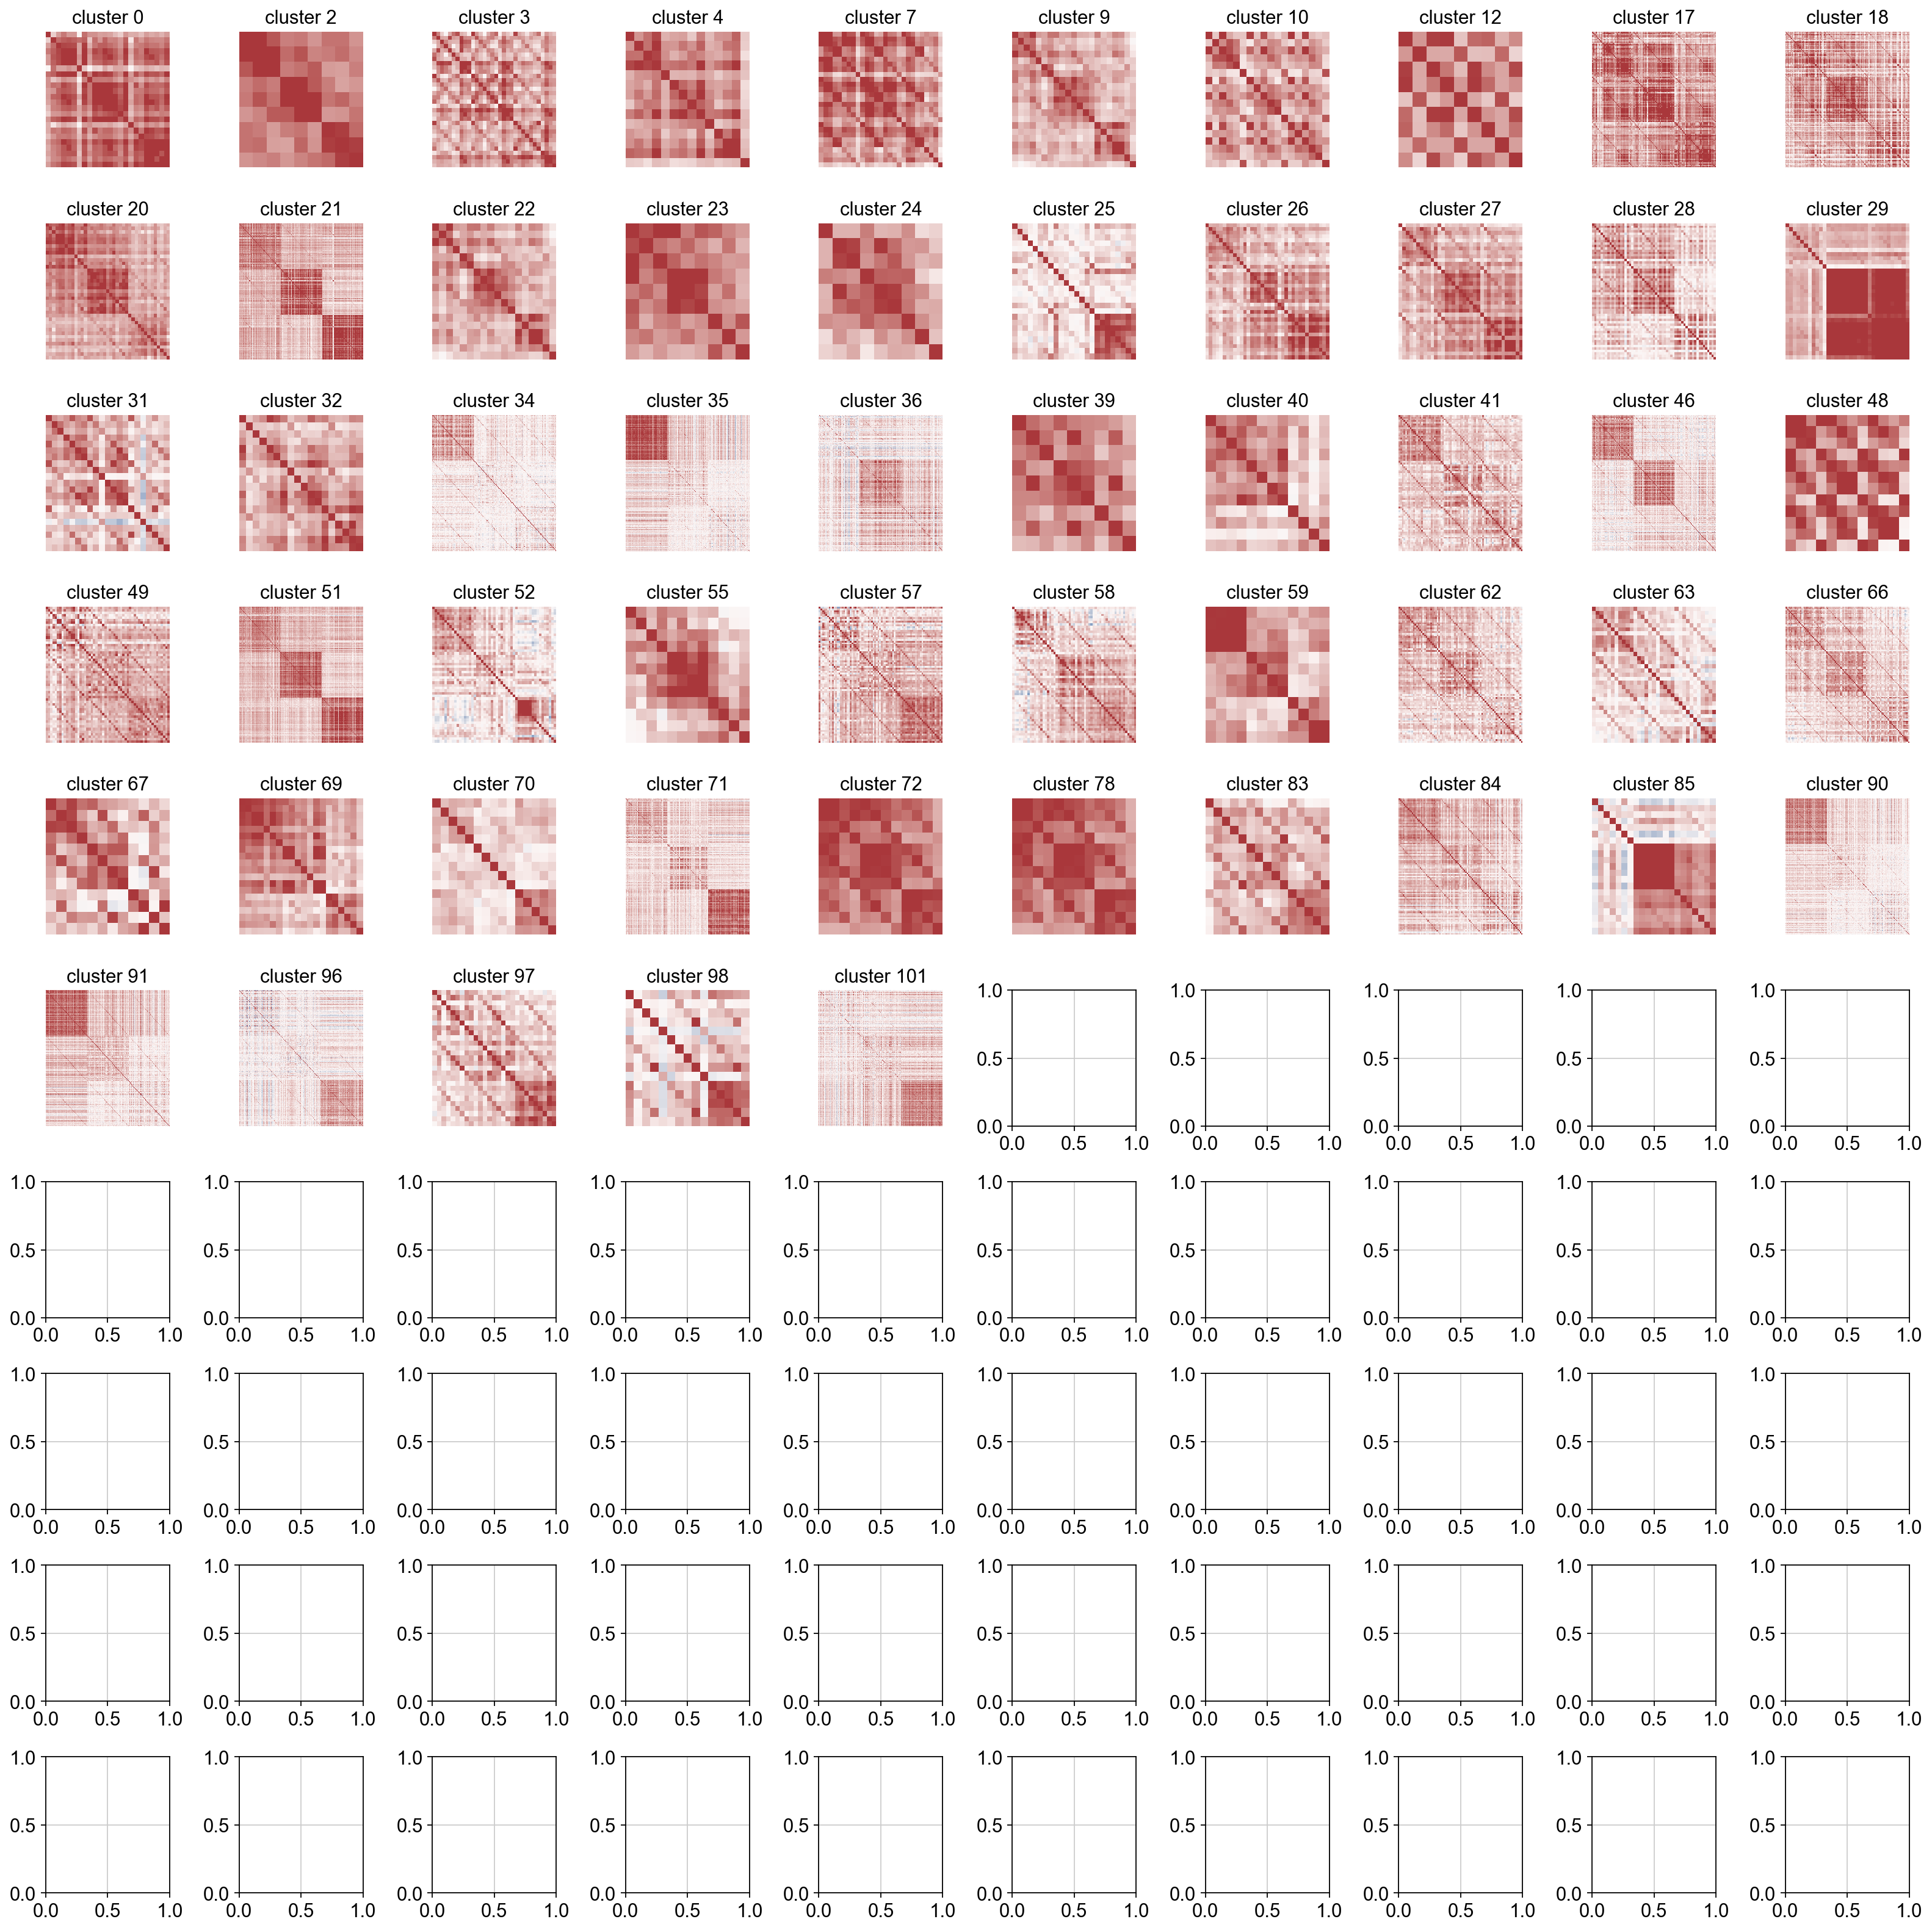

In [69]:
fig, axes = plt.subplots(10,10,figsize=(20,20))
ax = axes.flatten()
cluster_list = np.sort(adata_final.obs.hdbscan.unique())
for i in range(55):
    genelist = adata_final[adata_final.obs.hdbscan==cluster_list[i]].obs.target_contrast_gene_name_corrected.unique().tolist()
    corr_mtx = corr_compute(adata_de, genelist)
    sns.heatmap(corr_mtx, vmin=-0.5, vmax=0.5, cmap='vlag', ax=ax[i], xticklabels=[], yticklabels=[], cbar=False)
    ax[i].set_title('cluster '+str(cluster_list[i]))
plt.tight_layout()

In [70]:
adata_final[adata_final.obs.target_contrast_gene_name.str.startswith('MRPL')]

View of AnnData object with n_obs × n_vars = 41 × 10799
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast', 'chunk', 'n_cells_target', 'target_contrast_corrected', 'target_contrast_gene_name_corrected', 'hdbscan'
    var: 'gene_ids', 'gene_name'
    layers: 'adj_p_value', 'baseMean', 'lfcSE', 'log_fc', 'p_value', 'zscore'

In [107]:
adata_final[adata_final.obs.hdbscan==78].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000181090_Stim48hr                     EHMT1          Stim48hr   
ENSG00000204371_Stim48hr                     EHMT2          Stim48hr   
ENSG00000011451_Stim48hr                       WIZ          Stim48hr   
ENSG00000122482_Stim48hr                    ZNF644          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000181090_Stim48hr  ENSG00000181090   438          1626.0   
ENSG00000204371_Stim48hr  ENSG00000204371   324           629.0   
ENSG00000011451_Stim48hr  ENSG00000011451   504          1115.0   
ENSG00000122482_Stim48hr  ENSG00000122482   414           591.0   

                         target_contrast_corrected  \
ENSG00000181090_Stim48hr           ENSG00000181090   
ENSG00000204371_Stim48hr           ENSG00000204371   
ENSG00000011451_Stim48hr           ENSG00000011451   
ENSG00000122482_Stim48hr           ENSG00000122482   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000181090_Stim48hr                               EHMT1      78  
ENSG00000204371_Stim48hr                               EHMT2      78  
ENSG00000011451_Stim48hr                                 WIZ      78  
ENSG00000122482_Stim48hr                              ZNF644      78

In [104]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name_corrected.str.startswith('LCK')].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000182866_Stim8hr                        LCK           Stim8hr   
ENSG00000182866_Stim48hr                       LCK          Stim48hr   
ENSG00000182866_Rest                           LCK              Rest   

                          target_contrast chunk  n_cells_target  \
ENSG00000182866_Stim8hr   ENSG00000182866    59           116.0   
ENSG00000182866_Stim48hr  ENSG00000182866   432           107.0   
ENSG00000182866_Rest      ENSG00000182866   459           102.0   

                         target_contrast_corrected  \
ENSG00000182866_Stim8hr            ENSG00000182866   
ENSG00000182866_Stim48hr           ENSG00000182866   
ENSG00000182866_Rest               ENSG00000182866   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000182866_Stim8hr                                  LCK      36  
ENSG00000182866_Stim48hr                                 LCK     101  
ENSG00000182866_Rest                                     LCK      90

target_contrast target_name condition  n_cells_target  n_up_genes  \
2370   ENSG00000128683        GAD1  Stim48hr           733.0           0   
12462  ENSG00000128683        GAD1   Stim8hr           673.0           1   
31086  ENSG00000128683        GAD1      Rest           723.0           2   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2370              1                 1             -6.418918   
12462             1                 2             -4.389556   
31086             0                 2             -2.358590   

       ontarget_significant  baseMean  offtarget_flag n_total_genes_category  \
2370                   True  9.808407           False              1 DE gene   
12462                  True  4.670098           False          2-10 DE genes   
31086                 False  1.034175           False          2-10 DE genes   

      ontarget_effect_category target_contrast_corrected  \
2370              on-target KD           ENSG00000128683   
12462             on-target KD           ENSG00000128683   
31086          no on-target KD           ENSG00000128683   

                      obs_names target_name_corrected  
2370   ENSG00000128683_Stim48hr                  GAD1  
12462   ENSG00000128683_Stim8hr                  GAD1  
31086      ENSG00000128683_Rest                  GAD1

In [98]:
adata_cluster[adata_cluster.obs.target_contrast_gene_name=='ITK'].obs

target_contrast_gene_name culture_condition  \
ENSG00000113263_Stim8hr                        ITK           Stim8hr   
ENSG00000113263_Stim48hr                       ITK          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000113263_Stim8hr   ENSG00000113263   443           517.0   
ENSG00000113263_Stim48hr  ENSG00000113263   610           361.0   

                         target_contrast_corrected  \
ENSG00000113263_Stim8hr            ENSG00000113263   
ENSG00000113263_Stim48hr           ENSG00000113263   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000113263_Stim8hr                                  ITK      36  
ENSG00000113263_Stim48hr                                 ITK     101

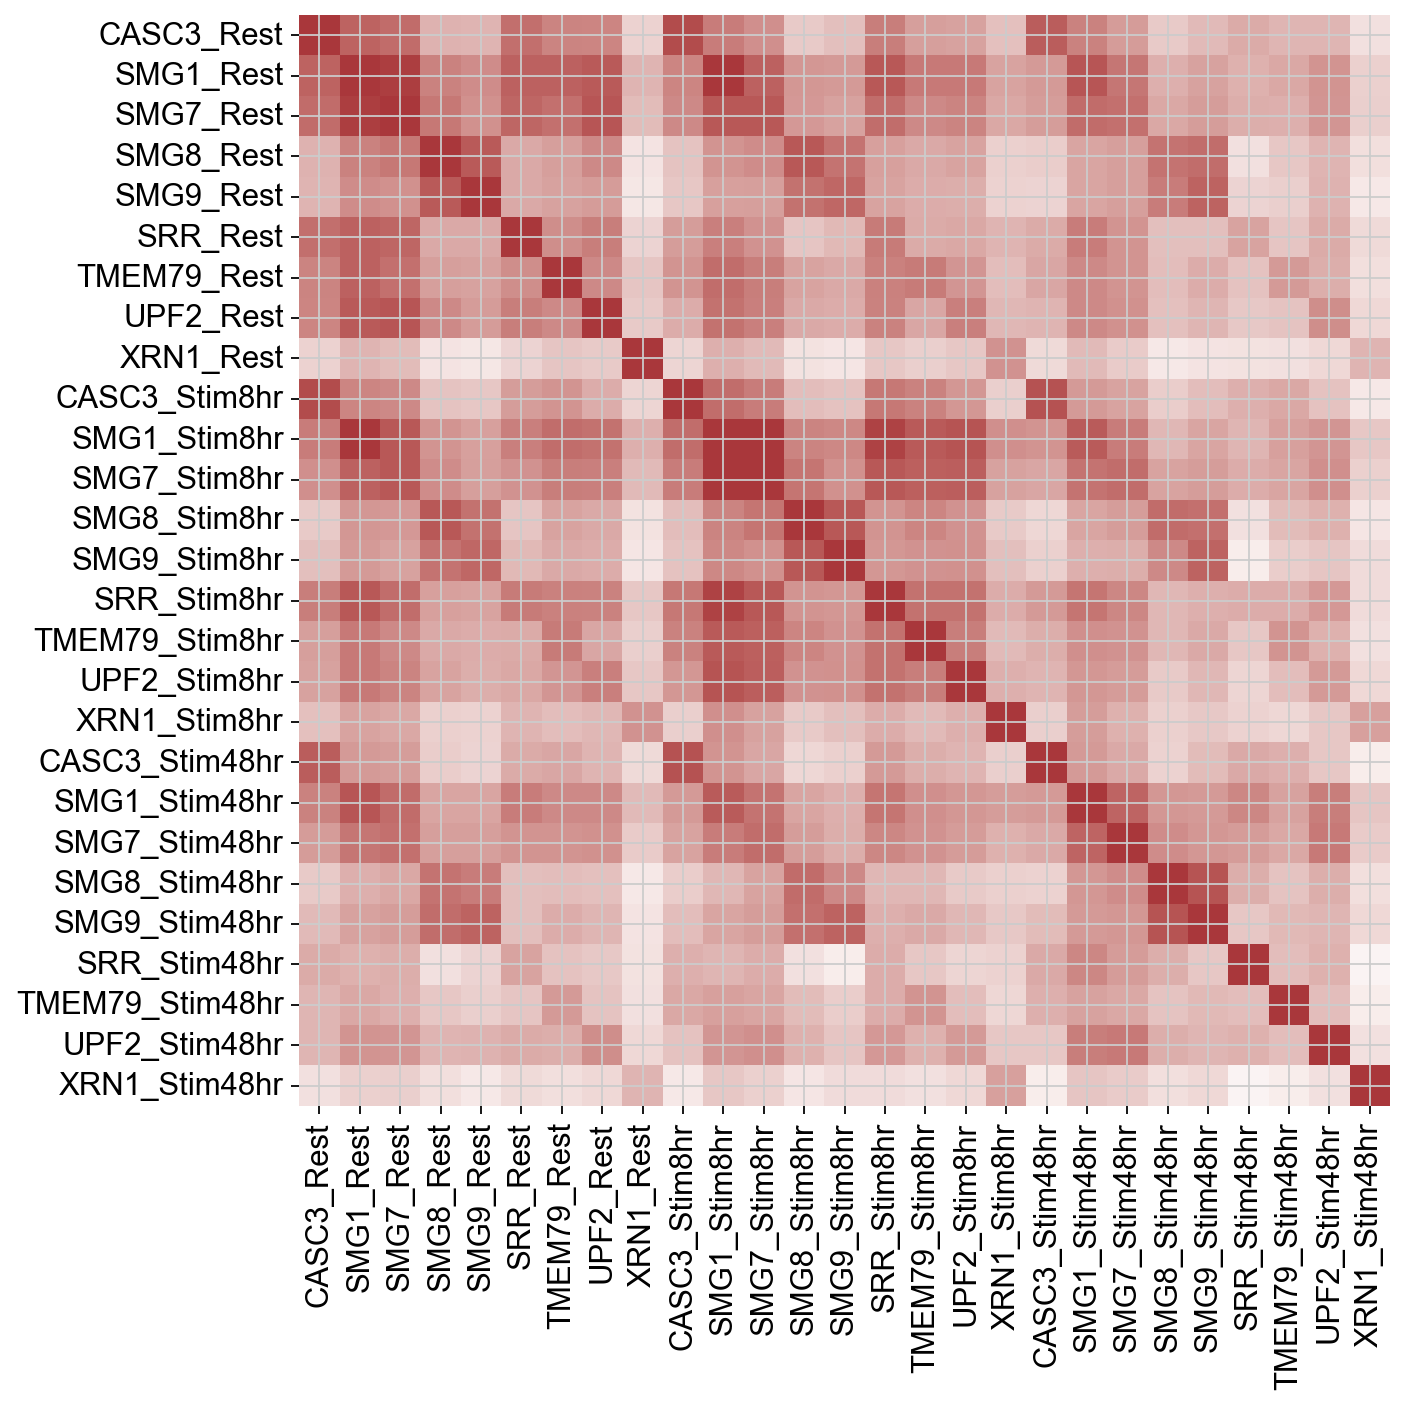

In [115]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==7].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster7.png')

In [89]:
adata_final[adata_final.obs.hdbscan==25].obs.target_contrast_gene_name_corrected.unique().tolist()

['SLC25A1', 'PDHB', 'MDH2', 'DLAT', 'PDHA1', 'CS', 'ACLY', 'STYXL1']

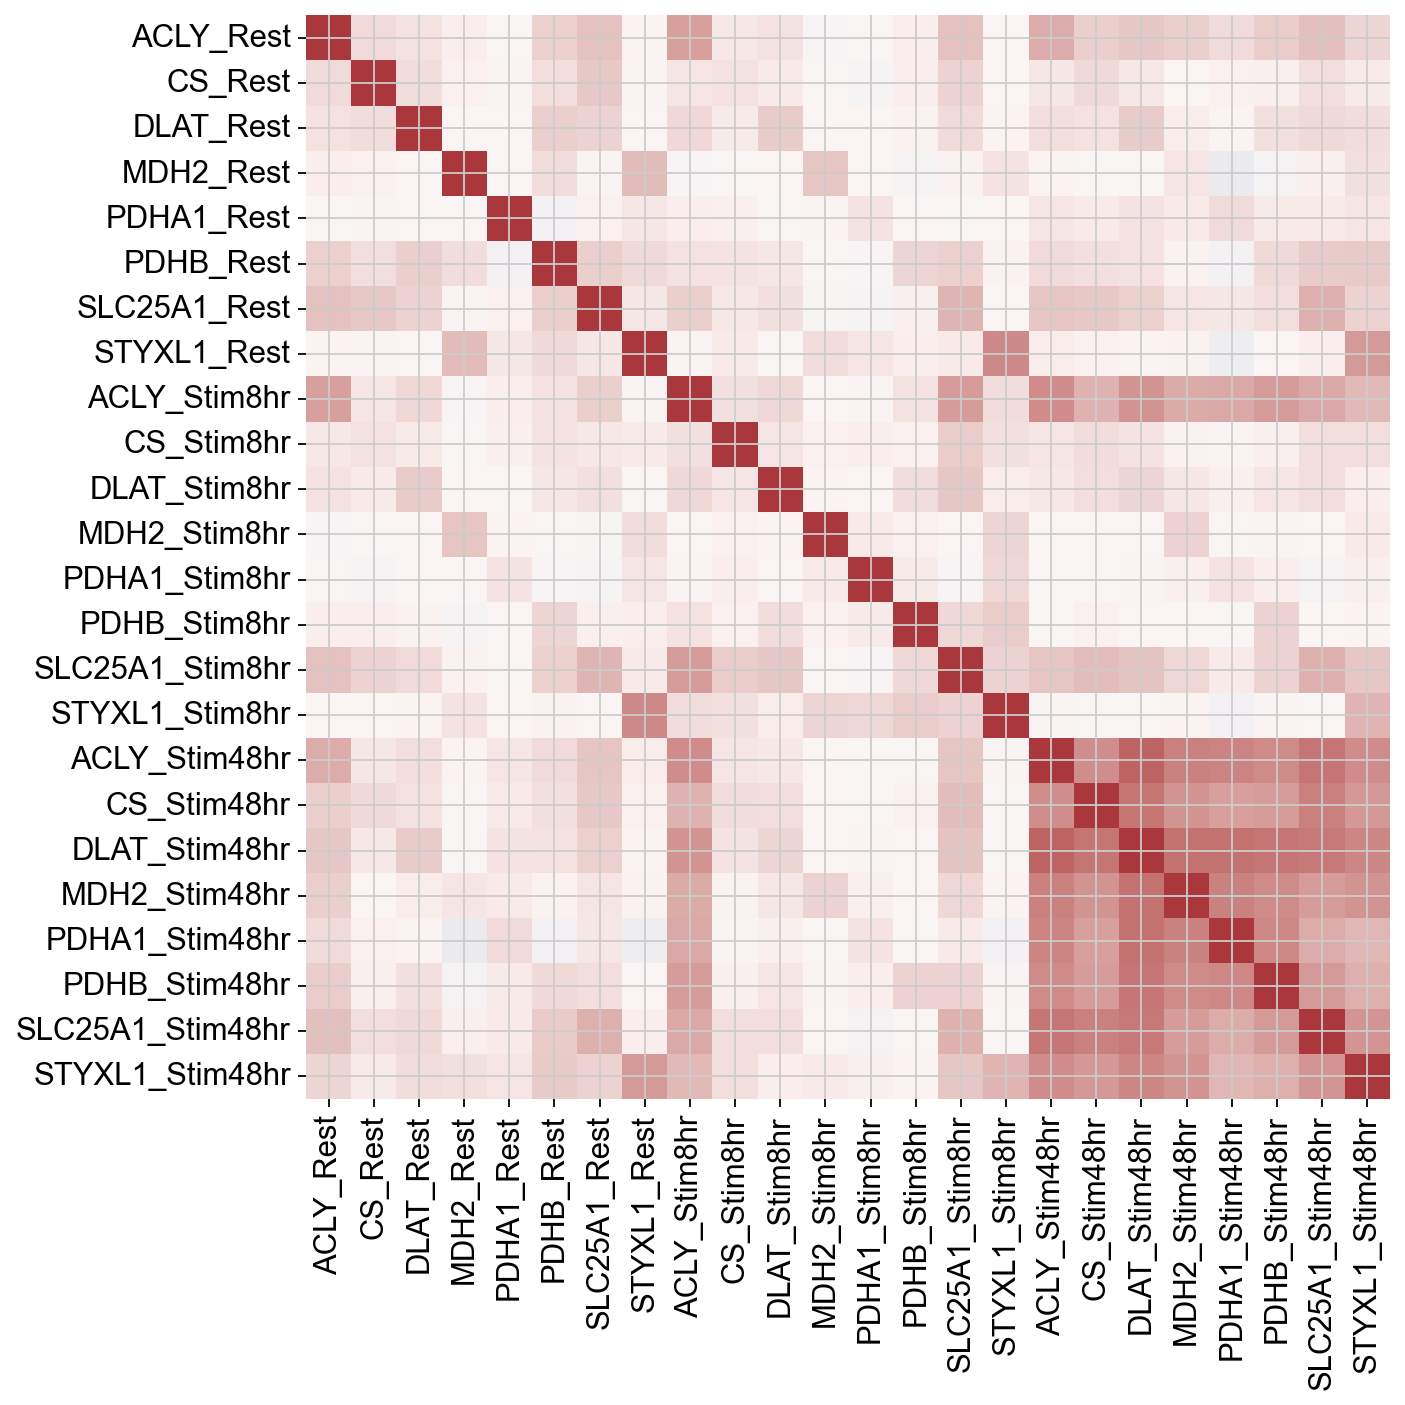

In [85]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==25].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster25.png')

In [103]:
de_summary_stats[de_summary_stats.target_name=='LCK']

target_contrast target_name condition  n_cells_target  n_up_genes  \
2984   ENSG00000182866         LCK   Stim8hr           116.0        1745   
21628  ENSG00000182866         LCK  Stim48hr           107.0         613   
22978  ENSG00000182866         LCK      Rest           102.0         103   

       n_down_genes  n_total_de_genes  ontarget_effect_size  \
2984            669              2414             -8.989515   
21628           303               916             -9.689431   
22978           206               309            -10.907615   

       ontarget_significant    baseMean  offtarget_flag  \
2984                   True  129.013733           False   
21628                  True  160.513650           False   
22978                  True  205.543259           False   

      n_total_genes_category ontarget_effect_category  \
2984            >10 DE genes             on-target KD   
21628           >10 DE genes             on-target KD   
22978           >10 DE genes             on-target KD   

      target_contrast_corrected                 obs_names  \
2984            ENSG00000182866   ENSG00000182866_Stim8hr   
21628           ENSG00000182866  ENSG00000182866_Stim48hr   
22978           ENSG00000182866      ENSG00000182866_Rest   

      target_name_corrected  
2984                    LCK  
21628                   LCK  
22978                   LCK

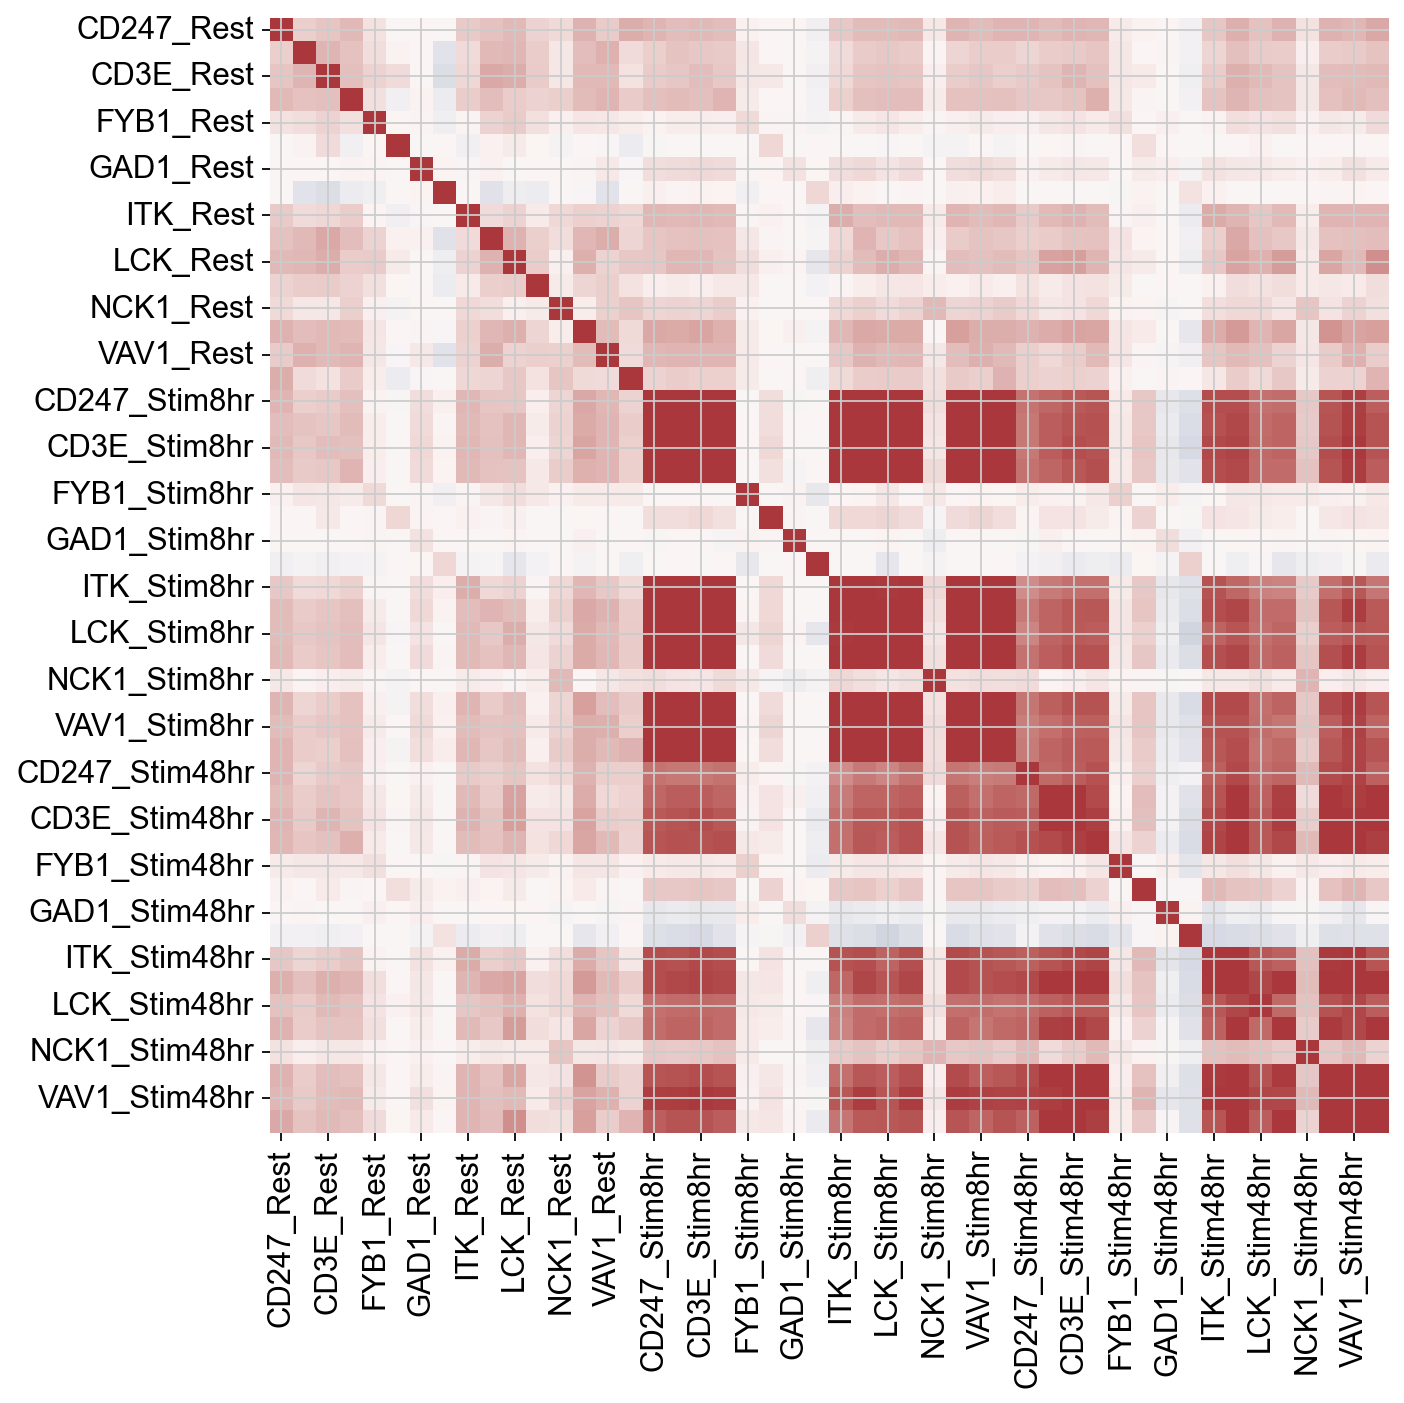

In [105]:
plt.figure(figsize=(9, 9))
genelist = adata_final[(adata_final.obs.hdbscan==29)&(adata_final.obs.target_contrast_gene_name!='BCAT2')&(adata_final.obs.target_contrast_gene_name!='ZBED3')].obs.target_contrast_gene_name_corrected.unique().tolist()
genelist = genelist + ['GRB2', 'GAD1', 'ITK', 'NCK1', 'FYB1', 'FYN', 'LCK']
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster29.png')

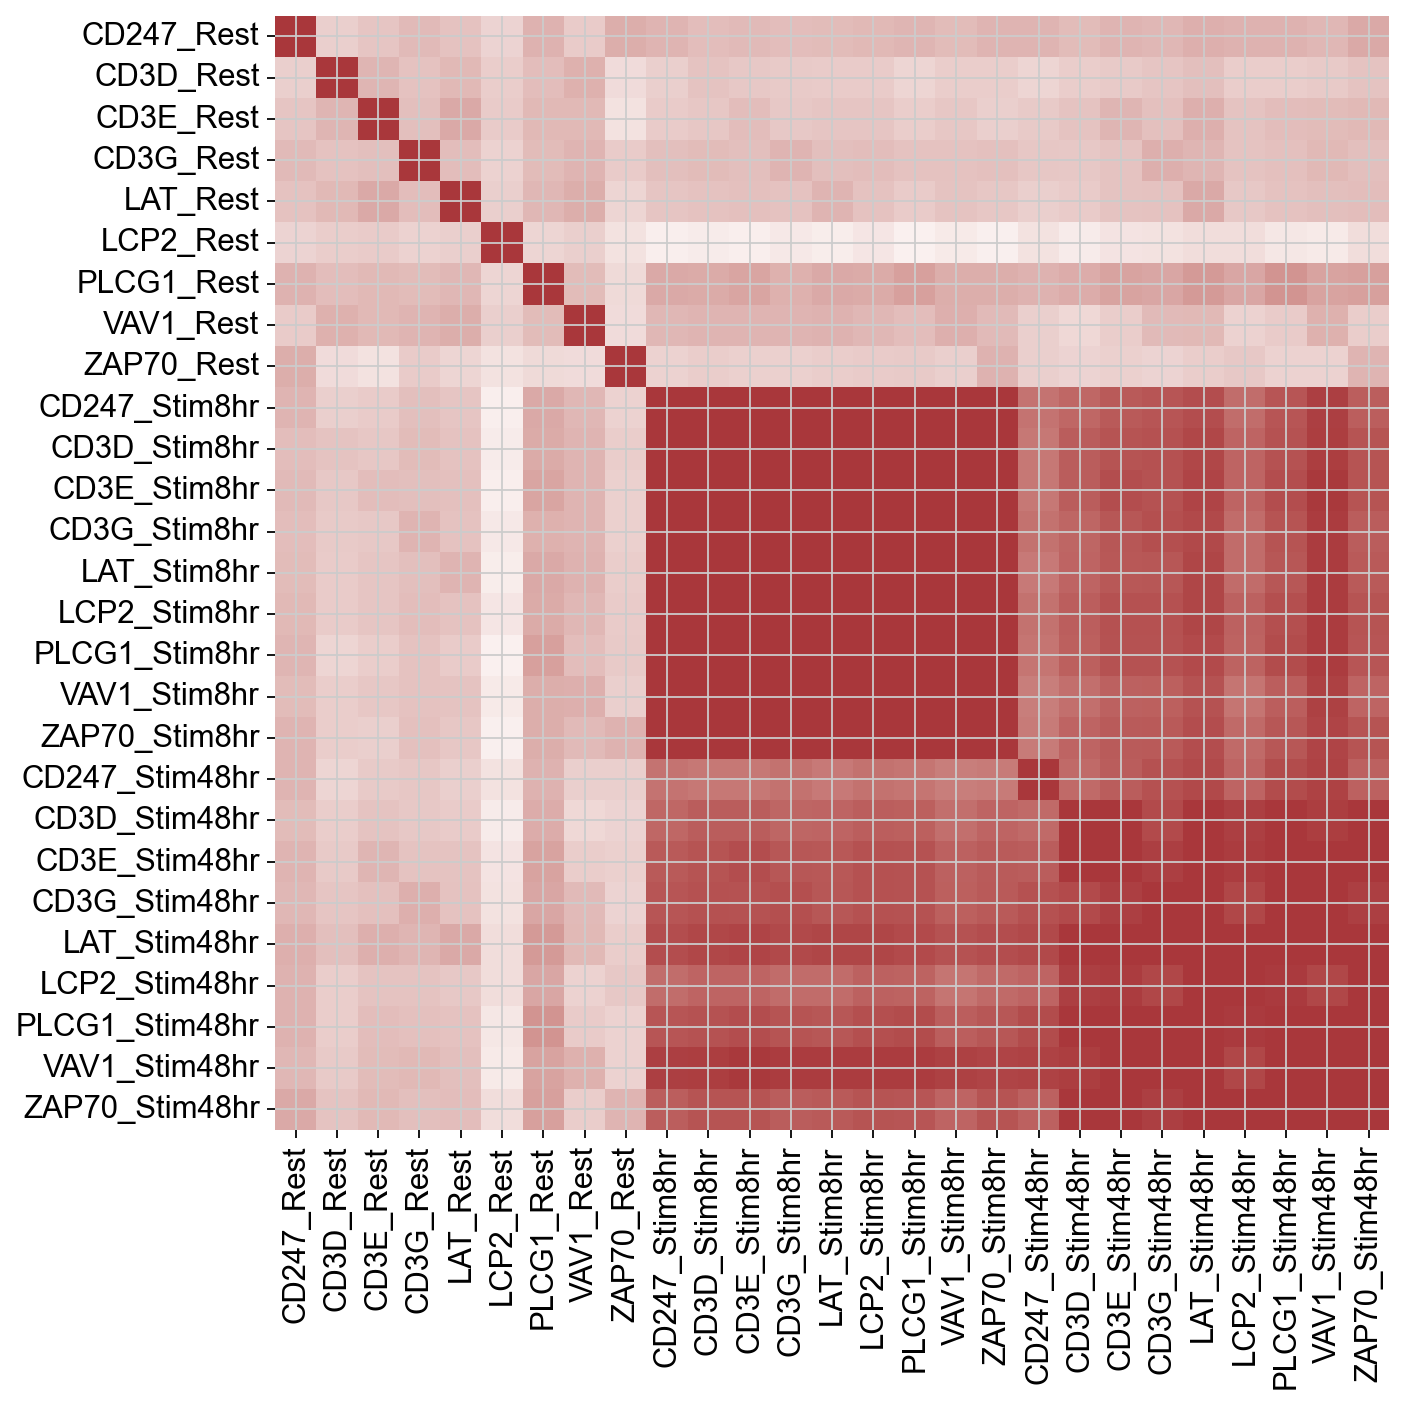

In [106]:
plt.figure(figsize=(9, 9))
genelist = adata_final[(adata_final.obs.hdbscan==29)&(adata_final.obs.target_contrast_gene_name!='BCAT2')&(adata_final.obs.target_contrast_gene_name!='ZBED3')].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=False)
plt.tight_layout()
plt.savefig('results/cluster29.png')

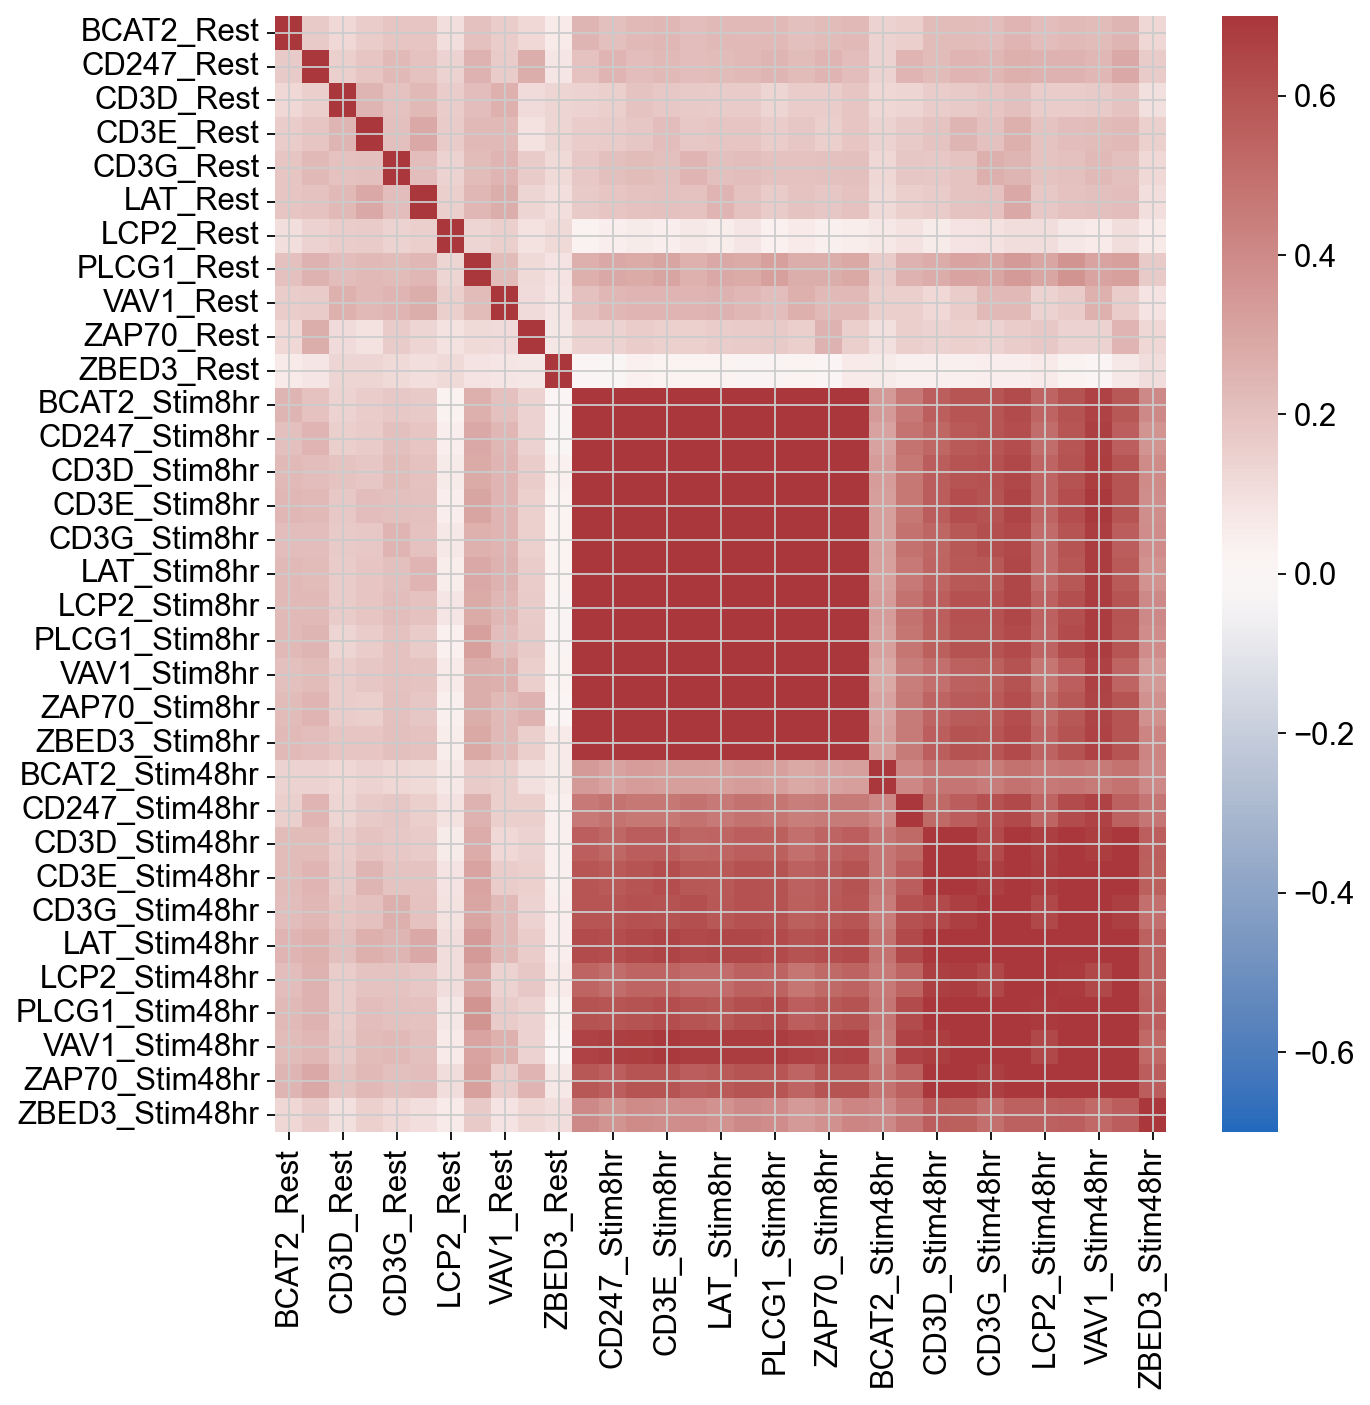

In [87]:
plt.figure(figsize=(9, 9))
genelist = adata_final[adata_final.obs.hdbscan==29].obs.target_contrast_gene_name_corrected.unique().tolist()
corr_mtx = corr_compute(adata_de, genelist)
sns.heatmap(corr_mtx, vmin=-0.7, vmax=0.7, cmap='vlag', cbar=True)
plt.tight_layout()
plt.savefig('results/colorbar0.7.png')

In [37]:
cluster_df[(cluster_df.intracluster_corr<0.2)&(cluster_df.cluster_gene_size>=5)]

cluster  intracluster_corr  cluster_size  cluster_gene_size  \
25       25           0.140295          21.0                9.0   
30       30           0.168900          16.0                8.0   
37       37           0.171560           7.0                6.0   
42       42           0.178128          11.0               11.0   
46       46           0.163973          99.0               57.0   
47       47           0.150139          15.0               15.0   
50       50           0.188514          45.0               44.0   
54       54           0.054538          45.0               27.0   
58       58           0.184500           6.0                6.0   
59       59           0.172770          40.0               40.0   
60       60           0.107564          70.0               69.0   
61       61           0.144730          27.0               19.0   
62       62           0.196344          74.0               73.0   
66       66           0.081469          12.0               12.0   
67       67           0.142190          17.0               14.0   
72       72           0.102889           7.0                7.0   
76       76           0.018664          52.0               45.0   
77       77           0.081563           8.0                5.0   
79       79           0.121424           6.0                6.0   
80       80           0.141374          11.0               11.0   
81       81           0.184018           5.0                5.0   
82       82           0.170182          17.0               17.0   
84       84           0.154942          73.0               73.0   
88       88           0.176332          21.0               21.0   
89       89           0.128020          15.0               15.0   
90       90           0.176932           5.0                5.0   
91       91           0.165445          72.0               72.0   
92       92           0.172595          10.0               10.0   
96       96           0.196787          80.0               79.0   
97       97           0.163416          14.0               14.0   

                                       cluster_member  
25  [CDKN2AIP, RBM12, WDR82, UBE3D, DNAAF2, DOP1A,...  
30  [ZFC3H1, THAP2, GPR137, ZC3H3, GPAA1, ZNF330, ...  
37         [PIBF1, BCLAF1, C1D, TTC5, FAM161A, STIM1]  
42  [PDCL, RICTOR, CBFB, POLDIP3, AGRN, EMC4, ZAP7...  
46  [TMEM131L, ACAD11, DDRGK1, CALR, ALG6, TGDS, D...  
47  [FLI1, SENP1, ELP6, EMX1, TMEM185A, MBTPS1, TM...  
50  [KLHDC10, ICOS, NEIL1, PXMP4, ZNF641, HPF1, CA...  
54  [CNOT11, TSTD2, SETD1B, PCYT2, WAC, CXXC1, KLF...  
58          [CREBBP, EP300, EME2, CBFB, KDM3B, CDCA3]  
59  [NIPBL, PXMP4, PDIA3, HSD17B13, ALKBH2, AK3, C...  
60  [IDH3A, SLC25A51, FAM20B, BRD1, PGS1, CMAS, IR...  
61  [KMT2C, RAB27B, SMARCC1, SMARCA4, SMARCB1, BHL...  
62  [FEM1A, PTPN1, NRBP1, CSK, APOBEC3B, UBXN1, CC...  
66  [MCEE, SPAG7, CWC27, PFAS, RAB27B, NAA40, ZFX,...  
67  [GIGYF2, TESPA1, TBL1X, DTX4, APOBEC3B, PRR12,...  
72  [JAKMIP2, IMMP2L, SUGP1, GCN1, ZNF254, ARL5B, ...  
76  [CDK5RAP3, NDUFB11, BLOC1S2, PAN3, SRSF6, PRPF...  
77                [CCDC6, GPR63, CARM1, ATP23, PA2G4]  
79             [PPP6C, RHEB, CYLD, CCR6, APC, POU3F1]  
80  [TMED9, TESK2, GNG5, MFSD6, SLC35B1, STK11, RB...  
81                   [SKIC3, TXNDC9, ARSK, AVEN, C1S]  
82  [CMTM7, SMAD3, AK3, RASGRP1, ICOS, ARMC8, FBXO...  
84  [ZNF574, GIGYF2, SP100, MAPK14, RRM2B, GLS, CL...  
88  [RHBDD3, MBIP, DMXL1, MTHFD1L, ZNF622, CLUH, R...  
89  [DEF8, SYNCRIP, USP10, DDX31, UBXN6, RBCK1, AT...  
90                [IPMK, PAICS, STAT3, IL21R, PABIR1]  
91  [ANKRD49, PHF3, XRCC2, STK11, RBM5, SIK3, STYX...  
92  [MFN2, PRUNE1, PPP1R11, GMEB2, UROS, DLD, TP53...  
96  [LMTK2, DUSP12, RBM27, NAF1, SARNP, CYTH3, GTF...  
97  [HSPA8, RSBN1L, SNRPB2, EIF3L, ANKRD11, PPIH, ...

In [69]:
adata_final[adata_final.obs.hdbscan==17].obs.sort_values(by='target_contrast_gene_name_corrected')

target_contrast_gene_name culture_condition  \
ENSG00000131473_Stim48hr                      ACLY          Stim48hr   
ENSG00000131473_Stim8hr                       ACLY           Stim8hr   
ENSG00000062485_Stim48hr                        CS          Stim48hr   
ENSG00000150768_Stim48hr                      DLAT          Stim48hr   
ENSG00000146701_Stim48hr                      MDH2          Stim48hr   
ENSG00000131828_Stim48hr                     PDHA1          Stim48hr   
ENSG00000168291_Stim48hr                      PDHB          Stim48hr   
ENSG00000138621_Rest                         PPCDC              Rest   
ENSG00000138621_Stim8hr                      PPCDC           Stim8hr   
ENSG00000127125_Rest                          PPCS              Rest   
ENSG00000127125_Stim8hr                       PPCS           Stim8hr   
ENSG00000100075_Stim48hr                   SLC25A1          Stim48hr   
ENSG00000127952_Stim48hr                    STYXL1          Stim48hr   

                          target_contrast chunk  n_cells_target  \
ENSG00000131473_Stim48hr  ENSG00000131473   570           282.0   
ENSG00000131473_Stim8hr   ENSG00000131473   645           396.0   
ENSG00000062485_Stim48hr  ENSG00000062485   469           232.0   
ENSG00000150768_Stim48hr  ENSG00000150768   392           372.0   
ENSG00000146701_Stim48hr  ENSG00000146701   182           998.0   
ENSG00000131828_Stim48hr  ENSG00000131828   454           192.0   
ENSG00000168291_Stim48hr  ENSG00000168291   155           303.0   
ENSG00000138621_Rest      ENSG00000138621   198           575.0   
ENSG00000138621_Stim8hr   ENSG00000138621   657           599.0   
ENSG00000127125_Rest      ENSG00000127125    41           137.0   
ENSG00000127125_Stim8hr   ENSG00000127125    97           138.0   
ENSG00000100075_Stim48hr  ENSG00000100075   102           521.0   
ENSG00000127952_Stim48hr  ENSG00000127952   671           753.0   

                         target_contrast_corrected  \
ENSG00000131473_Stim48hr           ENSG00000131473   
ENSG00000131473_Stim8hr            ENSG00000131473   
ENSG00000062485_Stim48hr           ENSG00000062485   
ENSG00000150768_Stim48hr           ENSG00000150768   
ENSG00000146701_Stim48hr           ENSG00000146701   
ENSG00000131828_Stim48hr           ENSG00000131828   
ENSG00000168291_Stim48hr           ENSG00000168291   
ENSG00000138621_Rest               ENSG00000138621   
ENSG00000138621_Stim8hr            ENSG00000138621   
ENSG00000127125_Rest               ENSG00000127125   
ENSG00000127125_Stim8hr            ENSG00000127125   
ENSG00000100075_Stim48hr           ENSG00000100075   
ENSG00000127952_Stim48hr           ENSG00000127952   

                         target_contrast_gene_name_corrected hdbscan  
ENSG00000131473_Stim48hr                                ACLY      17  
ENSG00000131473_Stim8hr                                 ACLY      17  
ENSG00000062485_Stim48hr                                  CS      17  
ENSG00000150768_Stim48hr                                DLAT      17  
ENSG00000146701_Stim48hr                                MDH2      17  
ENSG00000131828_Stim48hr                               PDHA1      17  
ENSG00000168291_Stim48hr                                PDHB      17  
ENSG00000138621_Rest                                   PPCDC      17  
ENSG00000138621_Stim8hr                                PPCDC      17  
ENSG00000127125_Rest                                    PPCS      17  
ENSG00000127125_Stim8hr                                 PPCS      17  
ENSG00000100075_Stim48hr                             SLC25A1      17  
ENSG00000127952_Stim48hr                              STYXL1      17

In [55]:
adata_final[adata_final.obs.hdbscan==40].obs.target_contrast_gene_name_corrected.unique().tolist()

['EDC3', 'LRP2BP', 'CAP1', 'EIF1AX', 'GATA3', 'PPDPF', 'SLC5A6']

In [135]:
adata_final[adata_final.obs.hdbscan==85].obs.target_contrast_gene_name_corrected.tolist()

['KMT2E', 'PKN3', 'TMEM44', 'HS3ST3B1', 'ROBO3', 'DNAJC3', 'MYO9A']

In [633]:
ind1 = np.where(adata.obs.index.isin(['ENSG00000181544_Stim8hr', 'ENSG00000187790_Stim8hr', 'ENSG00000112039_Stim8hr']))[0]
ind2 = np.where(adata.obs.index.isin(['ENSG00000084093_Stim8hr', 'ENSG00000126261_Stim8hr', 'ENSG00000197713_Stim8hr']))[0]
ind3 = np.where(adata.obs.index.isin(['ENSG00000106615_Rest', 'ENSG00000181754_Rest', 'ENSG00000105135_Rest']))[0]
ind = np.concatenate([ind1, ind2, ind3])
ind = np.concatenate([ind1, ind2])

ENSG00000181544_Stim8hr    0.229927
ENSG00000187790_Stim8hr    0.228583
ENSG00000112039_Stim8hr    0.226620
ENSG00000197713_Stim8hr    0.207617
ENSG00000084093_Stim8hr    0.138590
ENSG00000126261_Stim8hr    0.163671
dtype: float64


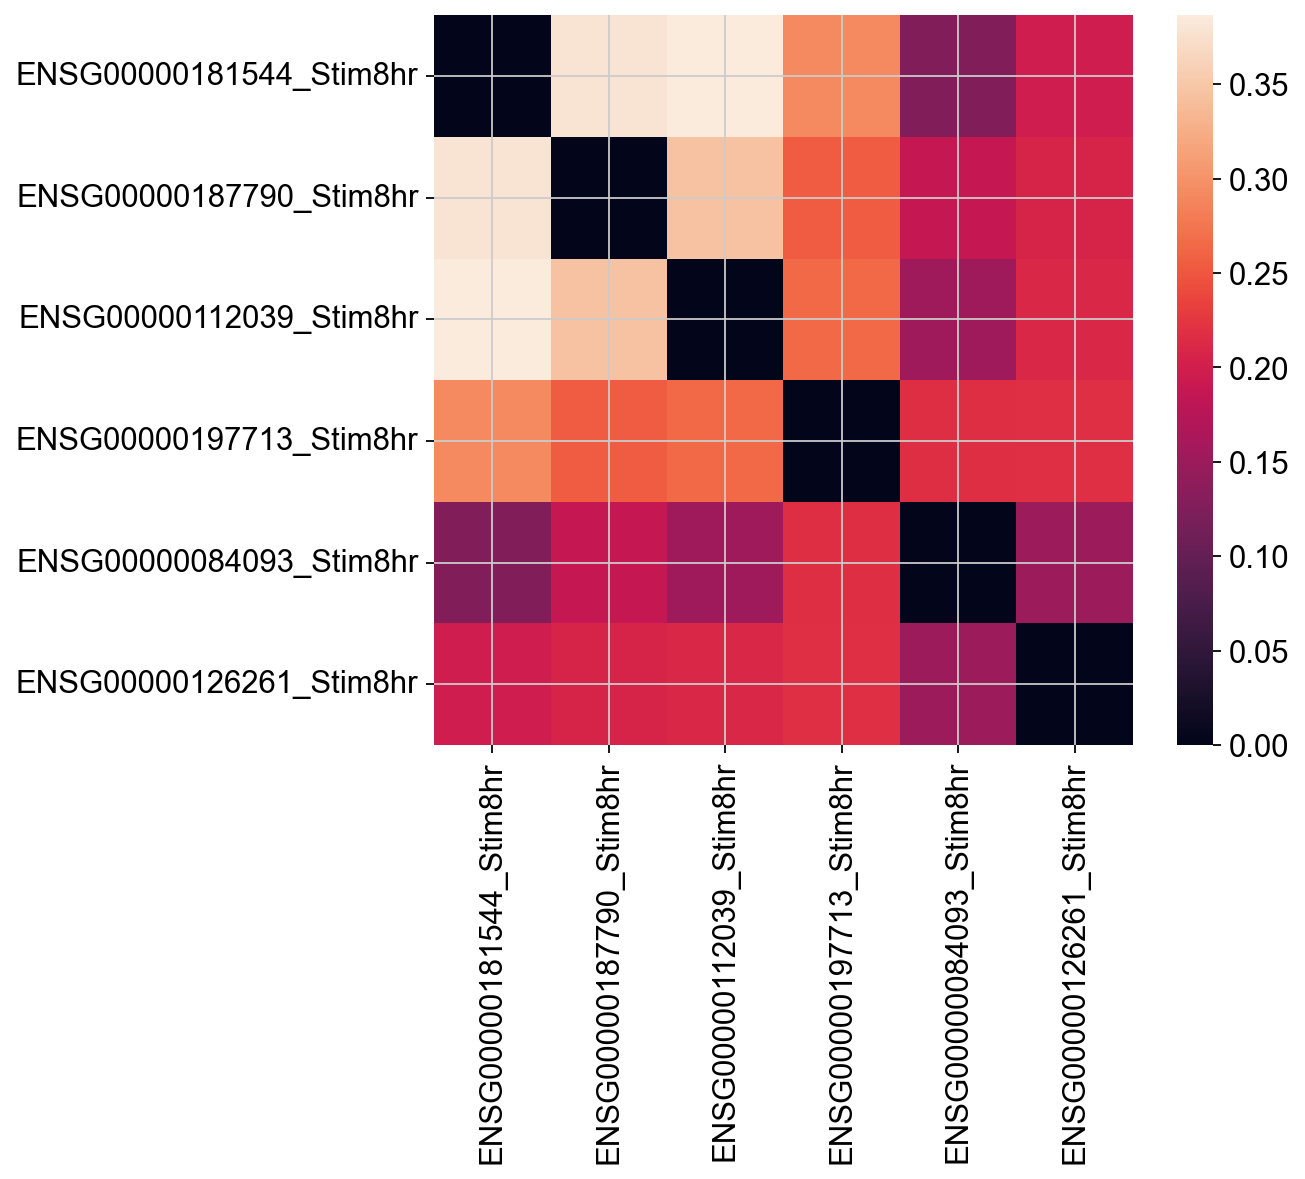

In [634]:
fig, ax = plt.subplots(figsize=(7,6))
test = pd.DataFrame(adata[ind,:].layers['zscore'].copy(),
                    index=adata[ind,:].obs.index,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())

In [638]:
cluster_df.iloc[196]

cluster                                                            196
correlation                                                   0.132266
cluster_size                                                      51.0
cluster_gene_size                                                 51.0
cluster_member       [XRCC2, STK11, RPE, PRKAR1A, REST, MFN2, SOCS4...
Name: 196, dtype: object

In [639]:
len(test2)

51

In [636]:
np.mean(test2)

0.2190102623292116

target_contrast_gene_name
XRCC2       0.155460
STK11       0.187877
RPE         0.145033
PRKAR1A     0.196557
REST        0.096093
MFN2        0.098684
SOCS4       0.133337
UBE2N       0.156684
UBA2        0.087478
MPP2        0.114244
ARPC1B      0.102885
LIG1        0.171957
NOP53       0.137614
CUL3        0.153088
BBS10       0.142966
RPL29       0.118924
DAXX        0.134098
CCS         0.160383
TIAF1       0.123710
ERCC4       0.173265
TMEM123     0.133618
MYB         0.124566
IPO9        0.109783
CHTF18      0.148957
RNASEH2A    0.107006
IFNGR1      0.082464
AKIRIN2     0.084143
UROS        0.135945
OTUB1       0.161529
UBE2T       0.131997
ZBTB7A      0.105865
SMAP2       0.161909
EIF2AK4     0.083367
TBCA        0.128584
VPS26B      0.148381
PPIL1       0.131701
FBRS        0.102919
OTUD1       0.162664
HOXB2       0.113378
FANCB       0.164285
FANCM       0.164143
ZFYVE21     0.082971
SRSF10      0.125804
SCAF11      0.092112
FANCE       0.156506
TBL1X       0.107938
RPUSD1  

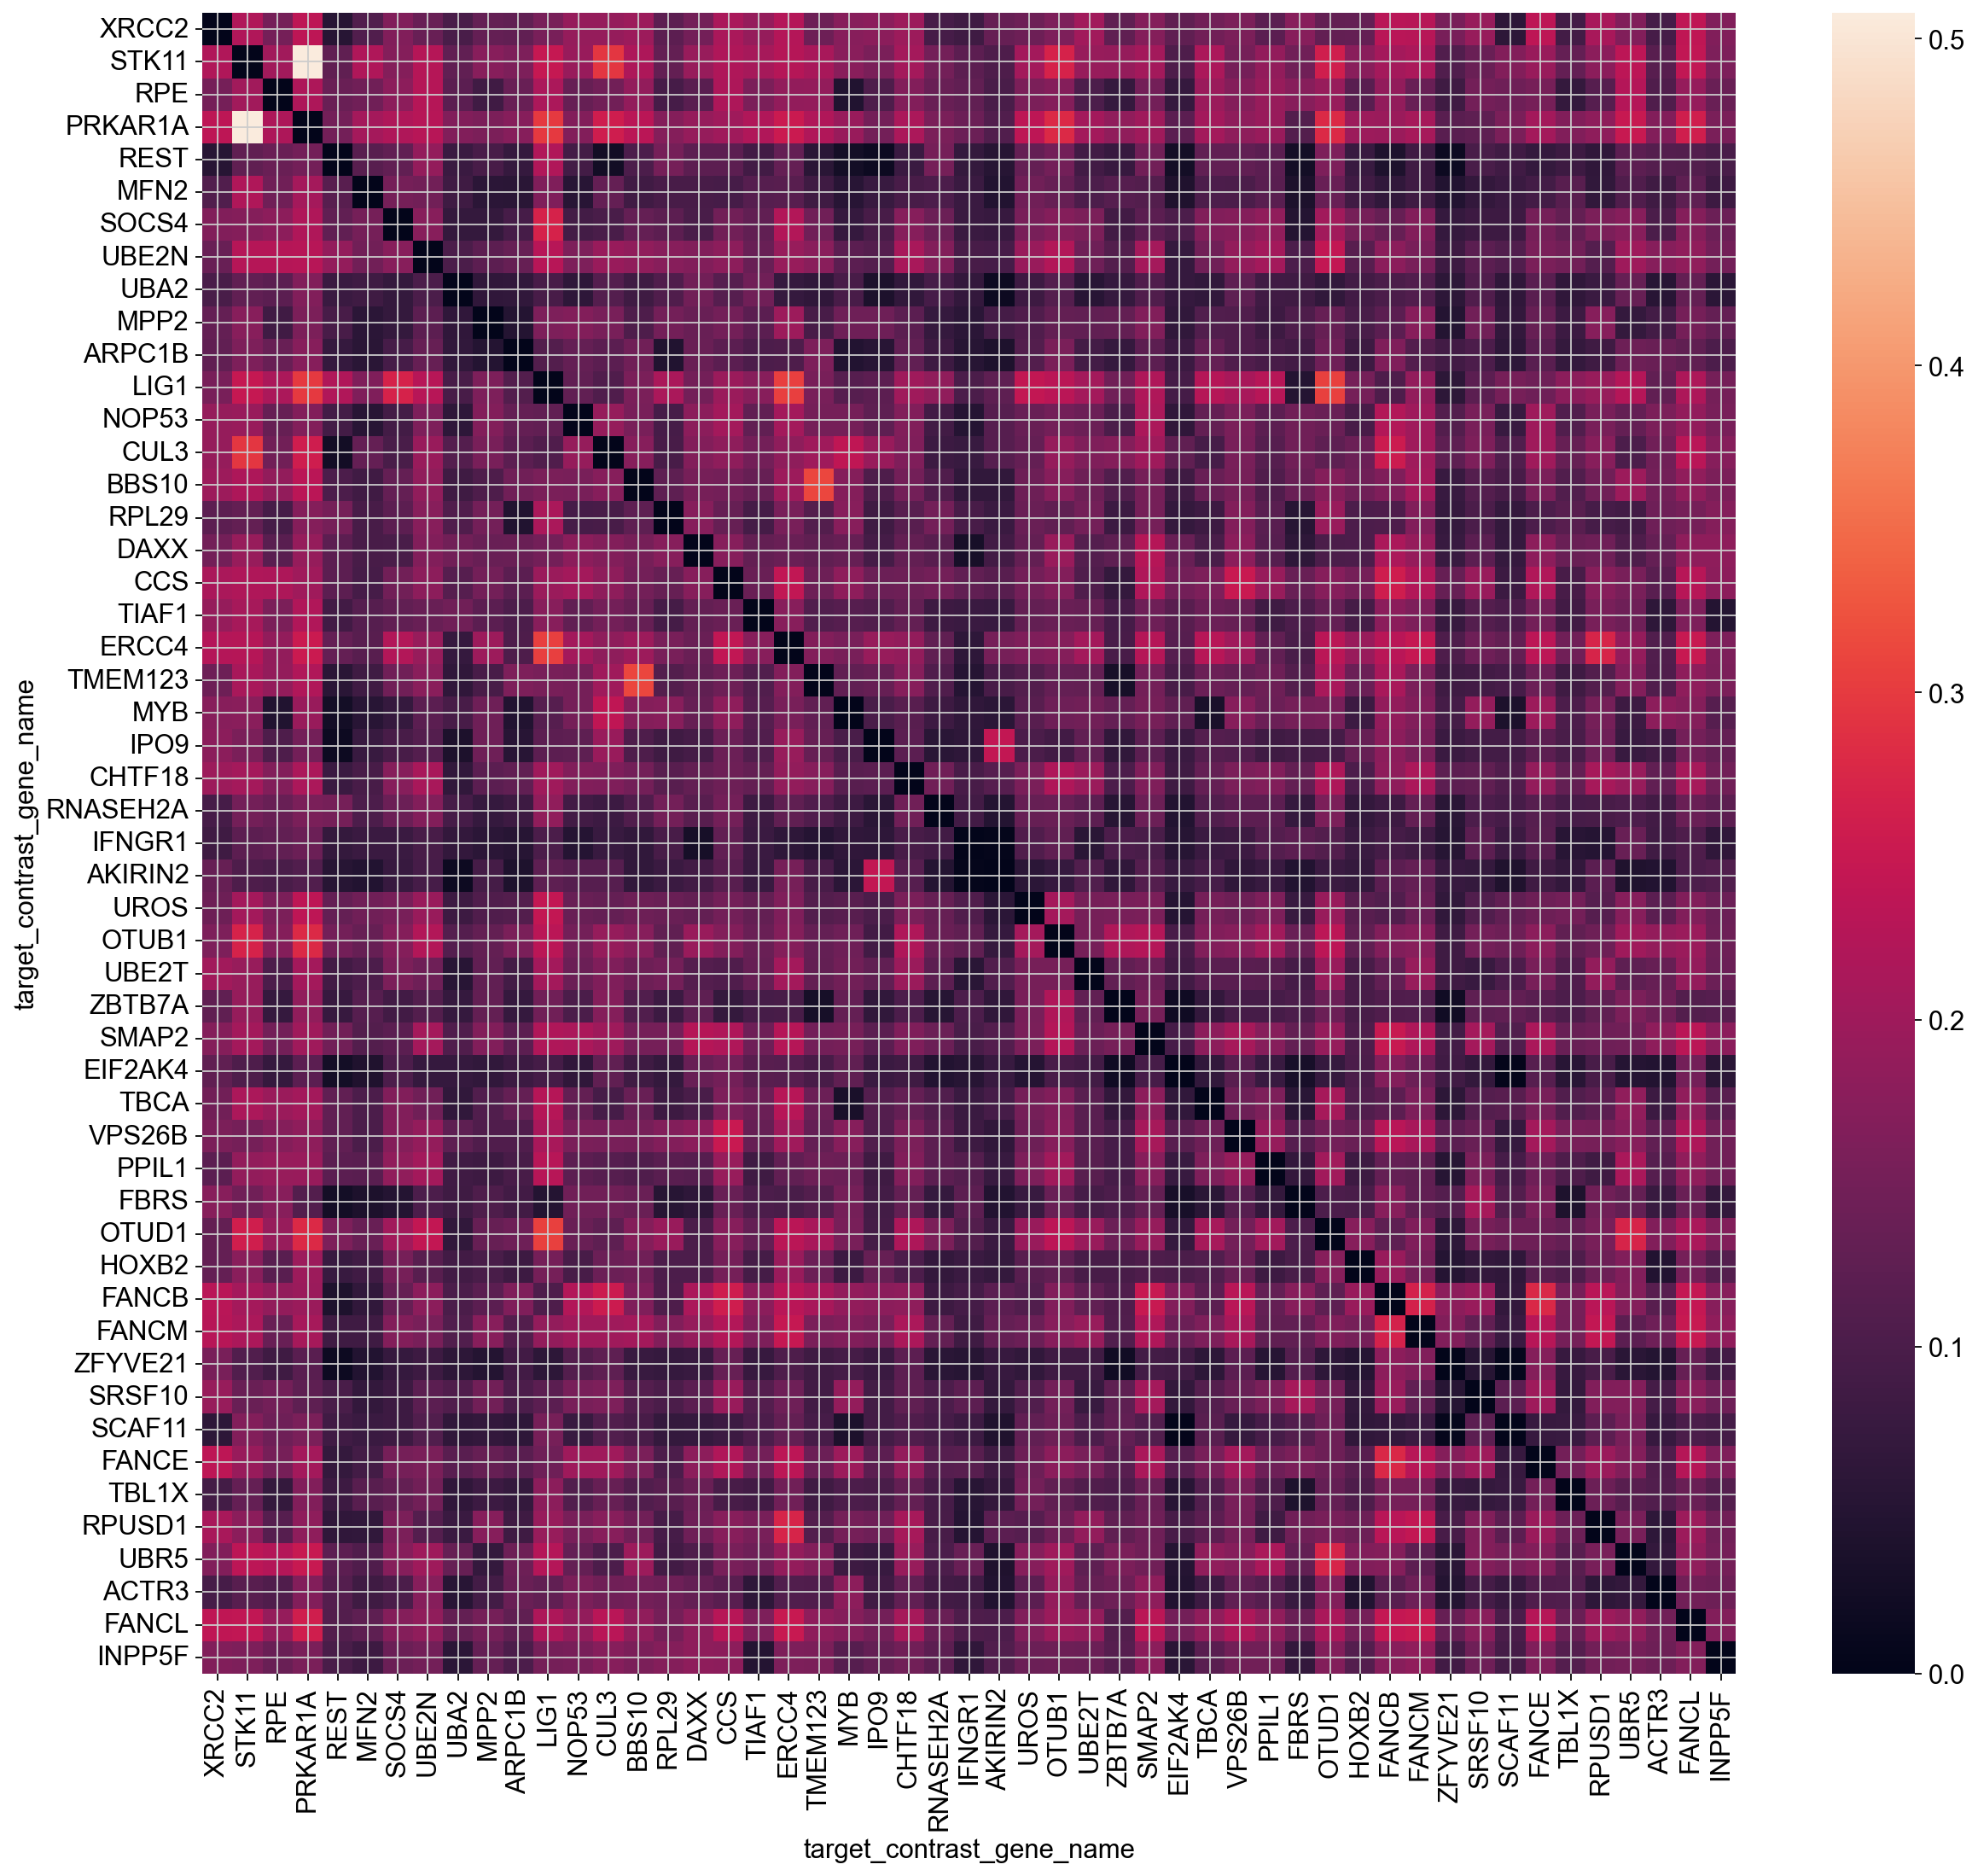

In [641]:
fig, ax = plt.subplots(figsize=(18,16))
test = pd.DataFrame(adata[adata.obs.hdbscan==196].X.copy(),
                    index=adata[adata.obs.hdbscan==196].obs.target_contrast_gene_name,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())

target_contrast_gene_name
XRCC2       0.251993
STK11       0.276370
RPE         0.239903
PRKAR1A     0.286010
REST        0.170421
MFN2        0.181922
SOCS4       0.220954
UBE2N       0.235484
UBA2        0.165897
MPP2        0.194984
ARPC1B      0.196420
LIG1        0.260427
NOP53       0.233821
CUL3        0.228241
BBS10       0.249525
RPL29       0.195119
DAXX        0.205384
CCS         0.258144
TIAF1       0.219291
ERCC4       0.263898
TMEM123     0.213682
MYB         0.206153
IPO9        0.186391
CHTF18      0.238871
RNASEH2A    0.188368
IFNGR1      0.167099
AKIRIN2     0.156660
UROS        0.234154
OTUB1       0.253307
UBE2T       0.211350
ZBTB7A      0.192541
SMAP2       0.251400
EIF2AK4     0.160848
TBCA        0.216539
VPS26B      0.248698
PPIL1       0.215955
FBRS        0.187264
OTUD1       0.252743
HOXB2       0.195839
FANCB       0.260649
FANCM       0.266563
ZFYVE21     0.168401
SRSF10      0.199740
SCAF11      0.173715
FANCE       0.252348
TBL1X       0.189730
RPUSD1  

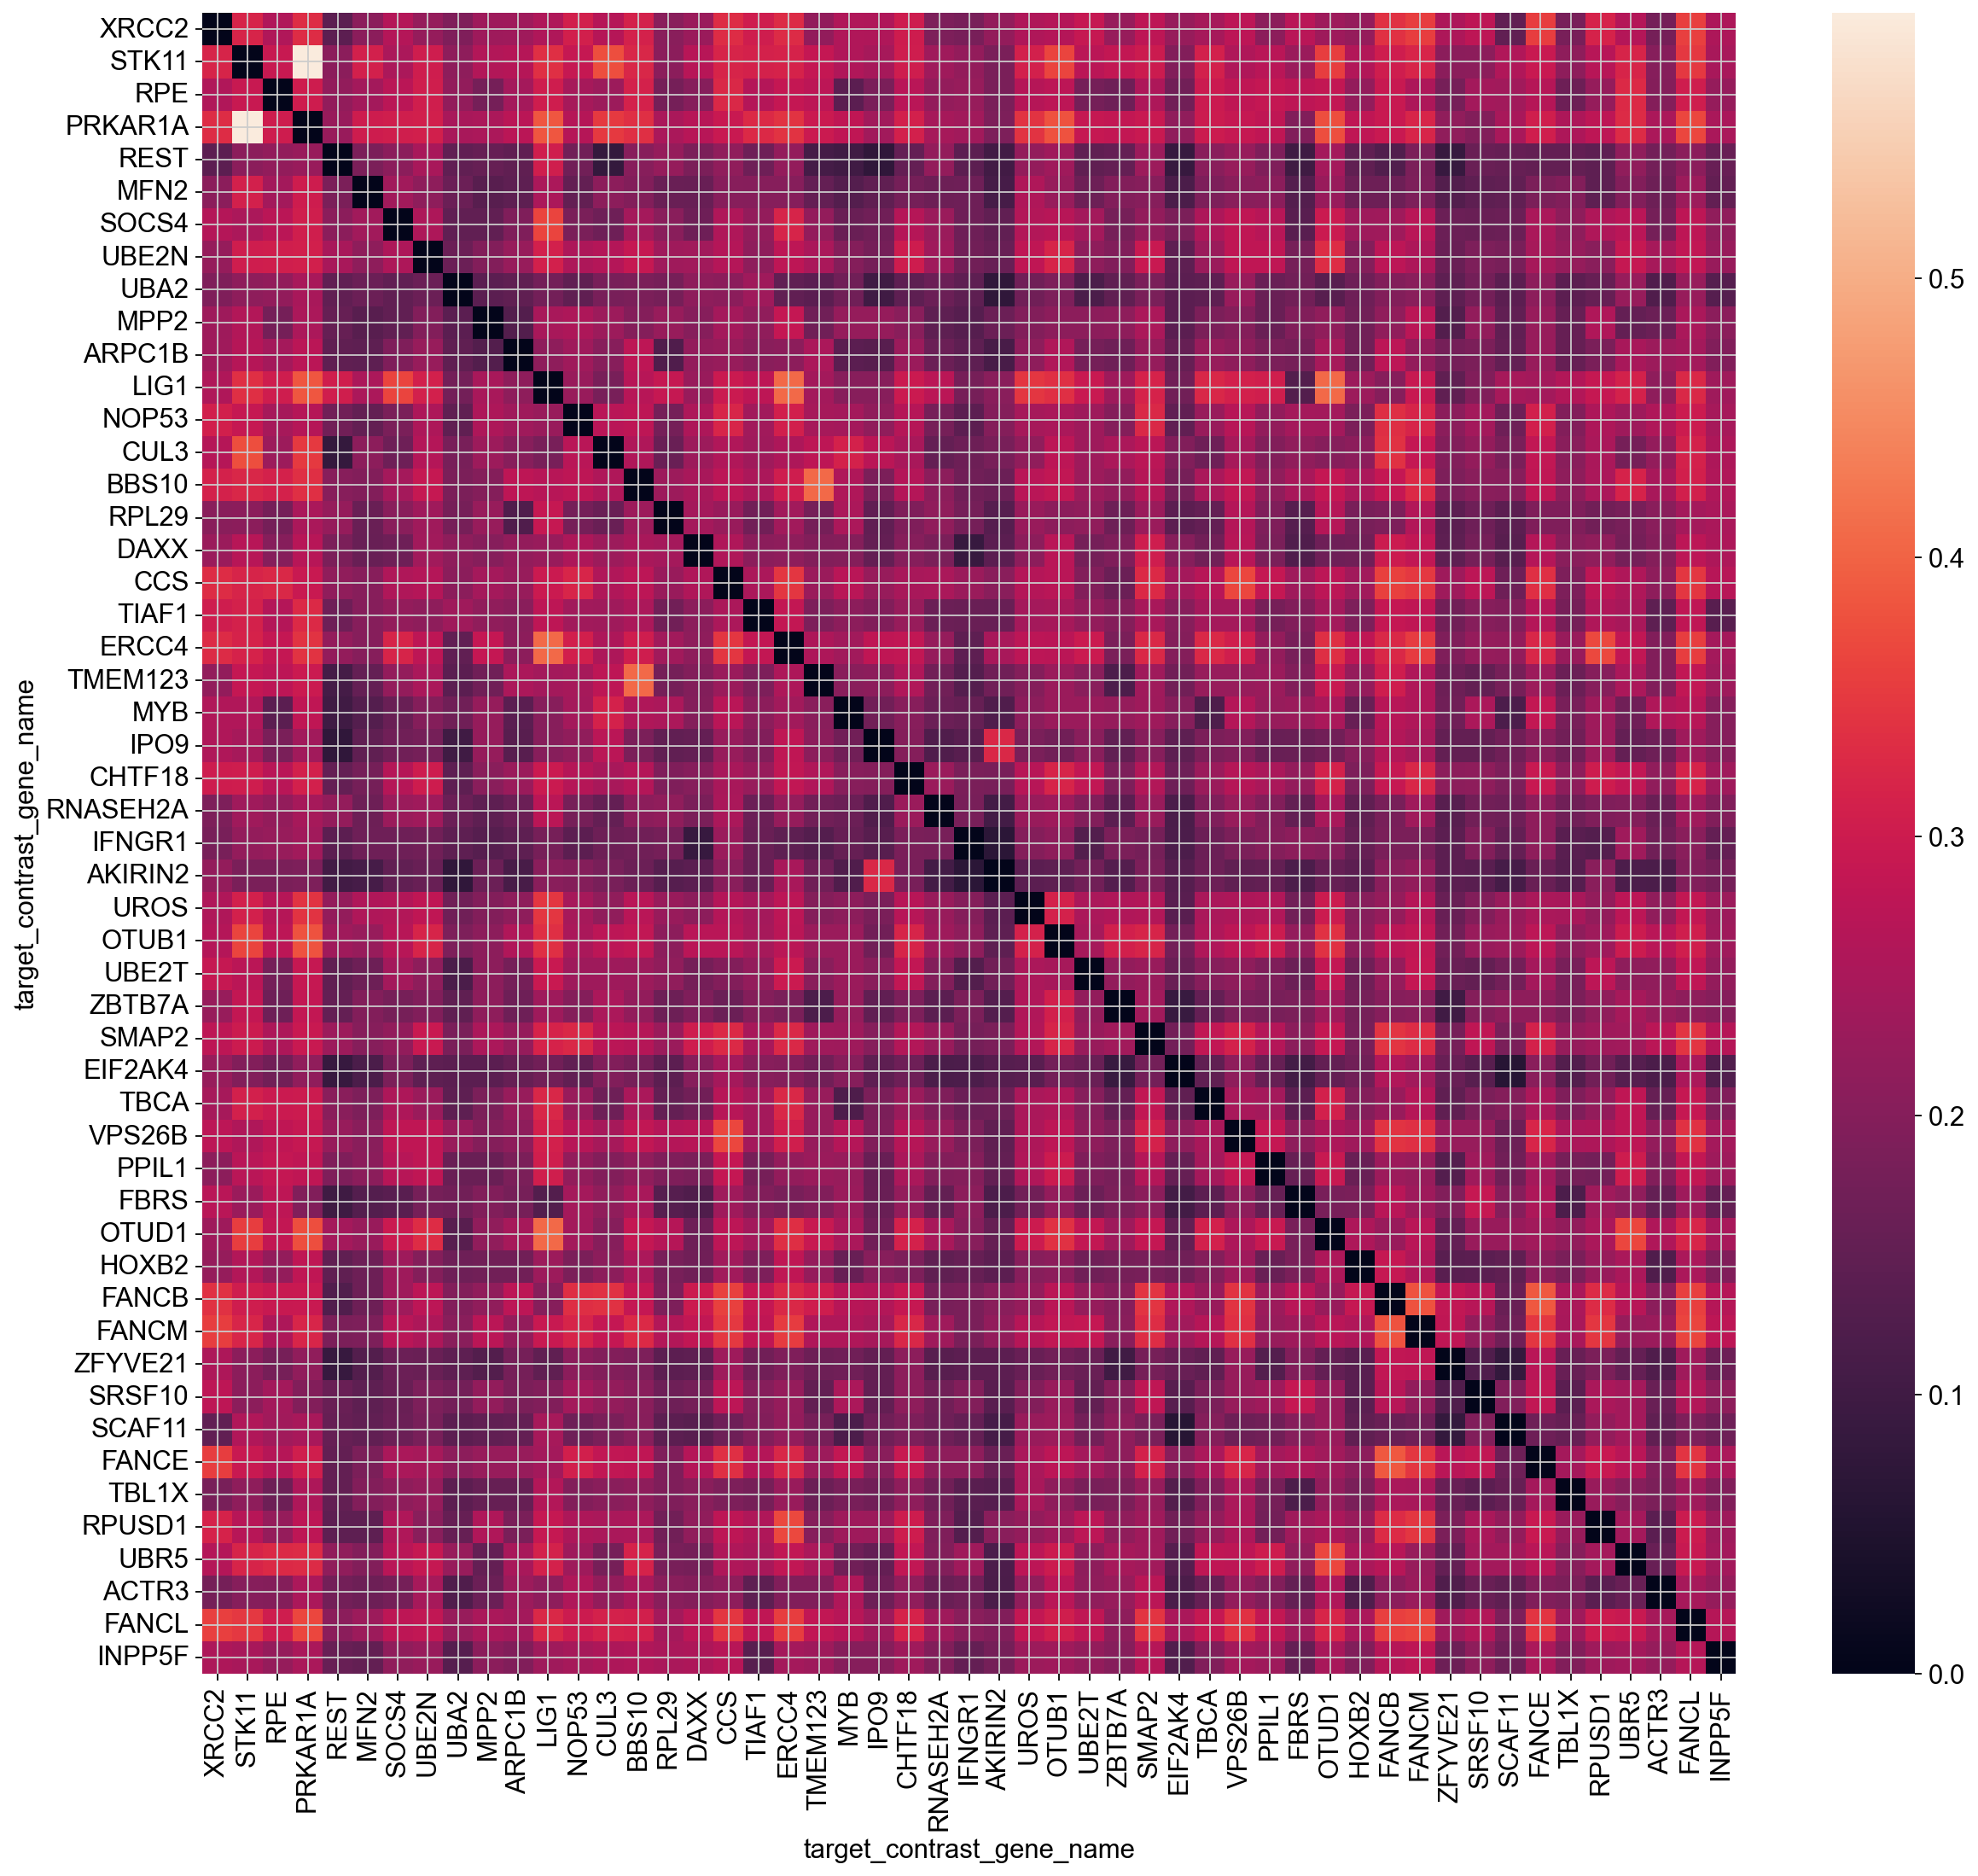

In [635]:
fig, ax = plt.subplots(figsize=(18,16))
test = pd.DataFrame(adata[adata.obs.hdbscan==196].layers['zscore'].copy(),
                    index=adata[adata.obs.hdbscan==196].obs.target_contrast_gene_name,
                    columns=adata.var_names)
test2 = test.T.corr()
np.fill_diagonal(test2.values, 0)
sns.heatmap(test2, ax=ax)
print(test2.mean())

In [562]:
cluster_df.iloc[196]

cluster                                                            196
correlation                                                   0.132266
cluster_size                                                      51.0
cluster_gene_size                                                 51.0
cluster_member       [XRCC2, STK11, RPE, PRKAR1A, REST, MFN2, SOCS4...
Name: 196, dtype: object

In [600]:
adata[adata.obs.hdbscan==196].obs

target_contrast_gene_name culture_condition  \
ENSG00000196584_Stim8hr                     XRCC2           Stim8hr   
ENSG00000118046_Stim8hr                     STK11           Stim8hr   
ENSG00000197713_Stim8hr                       RPE           Stim8hr   
ENSG00000108946_Stim8hr                   PRKAR1A           Stim8hr   
ENSG00000084093_Stim8hr                      REST           Stim8hr   
ENSG00000116688_Stim8hr                      MFN2           Stim8hr   
ENSG00000180008_Stim8hr                     SOCS4           Stim8hr   
ENSG00000177889_Stim8hr                     UBE2N           Stim8hr   
ENSG00000126261_Stim8hr                      UBA2           Stim8hr   
ENSG00000108852_Stim8hr                      MPP2           Stim8hr   
ENSG00000130429_Stim8hr                    ARPC1B           Stim8hr   
ENSG00000105486_Stim8hr                      LIG1           Stim8hr   
ENSG00000105373_Stim8hr                     NOP53           Stim8hr   
ENSG00000036257_Stim8hr                      CUL3           Stim8hr   
ENSG00000179941_Stim8hr                     BBS10           Stim8hr   
ENSG00000162244_Stim8hr                     RPL29           Stim8hr   
ENSG00000204209_Stim8hr                      DAXX           Stim8hr   
ENSG00000173992_Stim8hr                       CCS           Stim8hr   
ENSG00000196535_Stim8hr                     TIAF1           Stim8hr   
ENSG00000175595_Stim8hr                     ERCC4           Stim8hr   
ENSG00000152558_Stim8hr                   TMEM123           Stim8hr   
ENSG00000118513_Stim8hr                       MYB           Stim8hr   
ENSG00000198700_Stim8hr                      IPO9           Stim8hr   
ENSG00000127586_Stim8hr                    CHTF18           Stim8hr   
ENSG00000104889_Stim8hr                  RNASEH2A           Stim8hr   
ENSG00000027697_Stim8hr                    IFNGR1           Stim8hr   
ENSG00000135334_Stim8hr                   AKIRIN2           Stim8hr   
ENSG00000188690_Stim8hr                      UROS           Stim8hr   
ENSG00000167770_Stim8hr                     OTUB1           Stim8hr   
ENSG00000077152_Stim8hr                     UBE2T           Stim8hr   
ENSG00000178951_Stim8hr                    ZBTB7A           Stim8hr   
ENSG00000084070_Stim8hr                     SMAP2           Stim8hr   
ENSG00000128829_Stim8hr                   EIF2AK4           Stim8hr   
ENSG00000171530_Stim8hr                      TBCA           Stim8hr   
ENSG00000151502_Stim8hr                    VPS26B           Stim8hr   
ENSG00000137168_Stim8hr                     PPIL1           Stim8hr   
ENSG00000156860_Stim8hr                      FBRS           Stim8hr   
ENSG00000165312_Stim8hr                     OTUD1           Stim8hr   
ENSG00000173917_Stim8hr                     HOXB2           Stim8hr   
ENSG00000181544_Stim8hr                     FANCB           Stim8hr   
ENSG00000187790_Stim8hr                     FANCM           Stim8hr   
ENSG00000100711_Stim8hr                   ZFYVE21           Stim8hr   
ENSG00000188529_Stim8hr                    SRSF10           Stim8hr   
ENSG00000139218_Stim8hr                    SCAF11           Stim8hr   
ENSG00000112039_Stim8hr                     FANCE           Stim8hr   
ENSG00000101849_Stim8hr                     TBL1X           Stim8hr   
ENSG00000007376_Stim8hr                    RPUSD1           Stim8hr   
ENSG00000104517_Stim8hr                      UBR5           Stim8hr   
ENSG00000115091_Stim8hr                     ACTR3           Stim8hr   
ENSG00000115392_Stim8hr                     FANCL           Stim8hr   
ENSG00000198825_Stim8hr                    INPP5F           Stim8hr   

                         target_contrast chunk  n_cells_target leiden  \
ENSG00000196584_Stim8hr  ENSG00000196584    10           159.0      6   
ENSG00000118046_Stim8hr  ENSG00000118046    46           218.0      6   
ENSG00000197713_Stim8hr  ENSG00000197713   124           336.0      6   
ENSG00000108946_Stim8hr  ENSG0000010894

In [565]:
cluster_df[(cluster_df.correlation>0.1)&(cluster_df.correlation<=0.15)]

cluster  correlation  cluster_size  cluster_gene_size  \
13        13     0.123188           7.0                3.0   
17        17     0.122135           9.0                5.0   
24        24     0.107716           7.0                5.0   
25        25     0.103608          12.0                7.0   
32        32     0.123476           5.0                3.0   
39        39     0.108427          18.0                9.0   
45        45     0.138748          22.0                8.0   
50        50     0.137574          46.0               45.0   
66        66     0.134603           6.0                6.0   
87        87     0.124352          11.0               11.0   
98        98     0.105387         122.0              122.0   
106      106     0.100848          13.0               13.0   
111      111     0.111587           5.0                5.0   
116      116     0.110211          13.0               13.0   
120      120     0.117794          33.0               33.0   
121      121     0.121633          12.0               12.0   
124      124     0.141306           5.0                5.0   
127      127     0.113041          21.0               21.0   
129      129     0.140274          12.0               11.0   
137      137     0.108812           7.0                7.0   
138      138     0.147827         114.0              114.0   
141      141     0.137297          20.0               20.0   
147      147     0.101873           6.0                6.0   
150      150     0.110632           7.0                7.0   
151      151     0.127992          13.0               13.0   
155      155     0.149714           5.0                5.0   
161      161     0.119022           6.0                6.0   
166      166     0.121387          10.0               10.0   
167      167     0.143989           8.0                8.0   
168      168     0.110294          10.0               10.0   
170      170     0.116826          10.0               10.0   
180      180     0.113214          14.0               14.0   
183      183     0.127141           7.0                7.0   
184      184     0.120023           7.0                7.0   
185      185     0.139288           6.0                6.0   
187      187     0.136918          16.0               16.0   
193      193     0.123224          35.0               35.0   
196      196     0.132266          51.0               51.0   
198      198     0.148394           6.0                6.0   
199      199     0.115711          17.0               17.0   
202      202     0.123330           6.0                6.0   
203      203     0.104095          11.0               11.0   
204      204     0.109023          10.0               10.0   
205      205     0.110015          11.0               11.0   
207      207     0.124968          45.0               45.0   
208      208     0.115924           6.0                6.0   
209      209     0.145645           6.0                6.0   
212      212     0.131074           9.0                9.0   
214      214     0.118335          12.0               12.0   
226      226     0.147291          20.0               20.0   
229      229     0.136070           8.0                8.0   
230      230     0.112146          14.0               14.0   
231      231     0.134221           7.0                7.0   

                                        cluster_member  
13                    [CLASRP, CFAP20, C7orf55-LUC7L2]  
17               [KLHDC10, KDM2A, KMT2B, UBFD1, RAB2B]  
24              [NCOR1, C11orf68, CCNA2, HDAC3, RELL2]  
25   [MCTS1, DENR, GABPB1, BORCS8-MEF2B, CARNMT1, K...  
32                               [PIGB, GPR137, PDIA3]  
39   [ZNF200, TENT5C, PCGF1, FAM208B, KDM5C, PCGF6,...  
45   [CDKN2AIP, RBM12, RPRD1B, UBE3D, WDR82, DNAAF2...  
50   [SMS, CNBP, NOP53, TRRAP, TSC22D2, ZNF607, ERF...  
66       [UBE2V2, STAT1, ZC3H12A, ZBTB21, MUS81, USF2]  
87   [CMTM7, LUZP6, GYPC, ERGIC3, FBXO32, DOP1B, CD...  
98   [COG5, EML2, RAC2, CAMSA

In [601]:
clustering_temp = clustering_summary

In [607]:
cluster1 = []
cluster2 = []
cluster_size = []
for i in range(len(clustering_temp)):
    cluster1.append(clustering_temp.loc[i, 'leiden_assignment'][ind1].tolist())
    cluster2.append(clustering_temp.loc[i, 'leiden_assignment'][ind2].tolist())
    cluster_temp = clustering_temp.loc[i, 'leiden_assignment'][ind1].tolist()[0]
    cluster_size.append(np.sum(clustering_temp.loc[i, 'leiden_assignment']==cluster_temp))
clustering_temp['cluster1'] = cluster1
clustering_temp['cluster2'] = cluster2
clustering_temp['FANCE_cluster_size'] = cluster_size

In [608]:
clustering_temp

n_comp  n_neighbor  resolution  sil_score_raw  sil_score_pca  \
0       75          15           2       0.016427       0.058987   
1       75          15           3       0.011220       0.048698   
2       75          15           4       0.008050       0.034090   
3       75          31           2       0.015017       0.051422   
4       75          31           3       0.014618       0.054336   
5       75          31           4       0.010993       0.045087   
6       75          63           2       0.013317       0.052116   
7       75          63           3       0.009088       0.036808   
8       75          63           4       0.010214       0.036046   
9      100          15           2       0.011034       0.045614   
10     100          15           3       0.010825       0.047791   
11     100          15           4       0.008355       0.039186   
12     100          31           2       0.012542       0.050727   
13     100          31           3       0.011418       0.045958   
14     100          31           4       0.011323       0.041147   
15     100          63           2       0.015526       0.054762   
16     100          63           3       0.010976       0.038249   
17     100          63           4       0.008927       0.034339   
18     150          15           2       0.012643       0.047072   
19     150          15           3       0.012372       0.047672   
20     150          15           4       0.007960       0.038791   
21     150          31           2       0.012378       0.048374   
22     150          31           3       0.011900       0.045594   
23     150          31           4       0.013158       0.043933   
24     150          63           2       0.013328       0.044496   
25     150          63           3       0.011024       0.042345   
26     150          63           4       0.011809       0.043202   
27     250          15           2       0.013955       0.043510   
28     250          15           3       0.014249       0.042966   
29     250          15           4       0.009875       0.036212   
30     250          31           2       0.013420       0.042025   
31     250          31           3       0.005947       0.034408   
32     250          31           4       0.012609       0.040816   
33     250          63           2       0.014765       0.044066   
34     250          63           3       0.010923       0.038032   
35     250          63           4       0.011807       0.036002   

    ch_score_raw  ch_score_pca  db_score_raw  db_score_pca  \
0      22.958467     74.534779      4.435003      2.425253   
1      18.423818     61.241145      4.489873      2.527932   
2      15.956902     53.281551      4.475143      2.511294   
3      24.650208     77.349527      4.382809      2.379830   
4      21.010581     69.848063      4.568584      2.516332   
5      18.149377     61.555573      4.572742      2.514009   
6      28.603754     90.312897      4.508228      2.432423   
7      21.538062     69.695707      4.638048      2.506608   
8      19.760796     66.626909      4.680761      2.564799   
9      22.147139     66.326297      4.366449      2.502863   
10     18.361453     56.619809      4.505760      2.620479   
11     15.562669     48.308599      4.384954      2.546893   
12     24.053968     70.233244      4.300924      2.430508   
13     19.567139     60.328641      4.408050      2.492901   
14     16.651261     51.878216      4.365126      2.516467   
15     26.679473     77.847710      4.506996      2.526852   
16     20.776664     62.094888      4.479156      2.560273   
17     17.493875     54.447012      4.283013      2.444602   
18     20.413794     55.226112      4.458028      2.707455   
19     17.596082     48.984098      4.434349      2.688311   
20     14.681306     41.087459      4.307325      2.646022   
21     21.876017     57.826000      4.329767      2.607051   
22     18.116383     50.065573      4.198582      2.528811   